# <center> Energy Price Cannibalisation Due to Solar Power Generation in the UK Marker </center>

# Table of Contents
* [0. Set up](#0.-Set-up)
    * [0.1 Import necessary libraries](#0.1-Import-necessary-libraries)
* [1. Dataset #1](#1.-Dataset-#1)
    * [1.1 Get the data](#1.1-Get-the-data)
    * [1.2 Expore and clean the data](#1.2-Explore-and-clean-the-data)
    * [1.3 Feature engineering](#1.3-Feature-engineering)
* [2. Dataset #2](#2.-Dataset-#2)
    * [2.1 Get the data](#2.1-Get-the-data)
    * [2.2 Expore and clean the data](#2.2-Explore-and-clean-the-data)
    * [2.3 Feature engineering](#2.3-Feature-engineering)
* [3. Dataset #3](#3.-Dataset-#3)
    * [3.1 Get the data](#3.1-Get-the-data)
    * [3.2 Expore and clean the data](#3.2-Explore-and-clean-the-data)
* [4. Merge datasets](#4.-Merge-datasets)
* [5. Modelling](#5.-Modelling)
    * [5.1 Correlation (≠ causality)](#5.1-Correlation-(≠-causality))
    * [5.2 Model fit & Instrument validity](#5.2-Model-fit-&-Instrument-validity)
    * [5.3 2SLS](#5.3-2SLS)
    * [5.4 Robustness check](#5.4-Robustness-check)

# 0. Set up

## 0.1 Import necessary libraries

In [253]:
!pip install gdown

In [254]:
# Standard library
import requests

# Data handling
import pandas as pd
import xarray as xr

# Statistical modelling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import gdown

# 1. Dataset #1

## 1.1 Get the data

In [257]:
# Uses GitHub REST API to retrieve the list of .csv files in a given folder
def list_csv_files(owner, repo, folder):
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{folder}"
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request failed
    contents = response.json()
    # Filter for files that end with '.csv'
    return [item["name"] for item in contents if item["name"].endswith(".csv")]

# Set up repository and folder
owner = "tetiana-yashchenko"
repo = "Energy_Price_Cannibalisation"
base_path = "data/data_price"

# Define folders to loop through (data_price_1 to data_price_5)
folders = [f"{base_path}/data_price_{i}" for i in range(1, 6)]

dfs = []

# Loop over each folder and process all .csv files found
for folder in folders:
    try:
        csv_files = list_csv_files(owner, repo, folder)
        for fname in csv_files:
            raw_url = f"https://raw.githubusercontent.com/{owner}/{repo}/main/{folder}/{fname}"
            df = pd.read_csv(raw_url)
            df["source_file"] = f"{folder}/{fname}"
            dfs.append(df)
    except Exception:
        pass

# Combine all individual DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Print how many files were processed
print(f"Loaded {len(dfs)} files.")

# Show first few rows of the final combined DataFrame
combined_df.head()

Loaded 435 files.


,StartTime,DataProvider,SettlementDate,SettlementPeriod,Price,Volume,source_file,StartTime;DataProvider;SettlementDate;SettlementPeriod;Price;Volume
0,2017-01-07T23:30:00Z,APXMIDP,2017-01-07,48.0,43.14,474.00,data/data_price/data_price_1/MarketIndexPrices...,NaN
1,2017-01-07T23:30:00Z,N2EXMIDP,2017-01-07,48.0,0.00,0.00,data/data_price/data_price_1/MarketIndexPrices...,NaN
2,2017-01-07T23:00:00Z,APXMIDP,2017-01-07,47.0,43.58,573.95,data/data_price/data_price_1/MarketIndexPrices...,NaN
3,2017-01-07T23:00:00Z,N2EXMIDP,2017-01-07,47.0,0.00,0.00,data/data_price/data_price_1/MarketIndexPrices...,NaN
4,2017-01-07T22:30:00Z,APXMIDP,2017-01-07,46.0,46.14,458.90,data/data_price/data_price_1/MarketIndexPrices...,NaN


## 1.2 Explore and clean the data

In [259]:
# Drop column that accidentally holds the repeated header as a string
combined_df = combined_df.drop(columns=['StartTime;DataProvider;SettlementDate;SettlementPeriod;Price;Volume'], errors='ignore')

combined_df.head()

,StartTime,DataProvider,SettlementDate,SettlementPeriod,Price,Volume,source_file
0,2017-01-07T23:30:00Z,APXMIDP,2017-01-07,48.0,43.14,474.00,data/data_price/data_price_1/MarketIndexPrices...
1,2017-01-07T23:30:00Z,N2EXMIDP,2017-01-07,48.0,0.00,0.00,data/data_price/data_price_1/MarketIndexPrices...
2,2017-01-07T23:00:00Z,APXMIDP,2017-01-07,47.0,43.58,573.95,data/data_price/data_price_1/MarketIndexPrices...
3,2017-01-07T23:00:00Z,N2EXMIDP,2017-01-07,47.0,0.00,0.00,data/data_price/data_price_1/MarketIndexPrices...
4,2017-01-07T22:30:00Z,APXMIDP,2017-01-07,46.0,46.14,458.90,data/data_price/data_price_1/MarketIndexPrices...


In [260]:
# Filter the DataFrame to include only rows where the DataProvider is 'APXMIDP'
combined_df = combined_df[combined_df['DataProvider'] == 'APXMIDP']

combined_df.head()

,StartTime,DataProvider,SettlementDate,SettlementPeriod,Price,Volume,source_file
0,2017-01-07T23:30:00Z,APXMIDP,2017-01-07,48.0,43.14,474.00,data/data_price/data_price_1/MarketIndexPrices...
2,2017-01-07T23:00:00Z,APXMIDP,2017-01-07,47.0,43.58,573.95,data/data_price/data_price_1/MarketIndexPrices...
4,2017-01-07T22:30:00Z,APXMIDP,2017-01-07,46.0,46.14,458.90,data/data_price/data_price_1/MarketIndexPrices...
6,2017-01-07T22:00:00Z,APXMIDP,2017-01-07,45.0,46.38,386.70,data/data_price/data_price_1/MarketIndexPrices...
8,2017-01-07T21:30:00Z,APXMIDP,2017-01-07,44.0,47.43,563.00,data/data_price/data_price_1/MarketIndexPrices...


In [261]:
# Convert the 'StartTime' column to datetime format
combined_df['StartTime'] = pd.to_datetime(combined_df['StartTime'], errors='coerce')

combined_df['StartTime'].dtype

datetime64[ns, UTC]

In [262]:
# Sort the DataFrame by 'StartTime' in ascending order and reset the index
combined_df = combined_df.sort_values(by='StartTime').reset_index(drop=True)

combined_df.head()

,StartTime,DataProvider,SettlementDate,SettlementPeriod,Price,Volume,source_file
0,2017-01-01 00:00:00+00:00,APXMIDP,2017-01-01,1.0,44.90,505.00,data/data_price/data_price_1/MarketIndexPrices...
1,2017-01-01 00:30:00+00:00,APXMIDP,2017-01-01,2.0,47.13,559.15,data/data_price/data_price_1/MarketIndexPrices...
2,2017-01-01 01:00:00+00:00,APXMIDP,2017-01-01,3.0,45.62,649.35,data/data_price/data_price_1/MarketIndexPrices...
3,2017-01-01 01:30:00+00:00,APXMIDP,2017-01-01,4.0,44.05,712.65,data/data_price/data_price_1/MarketIndexPrices...
4,2017-01-01 02:00:00+00:00,APXMIDP,2017-01-01,5.0,44.83,599.15,data/data_price/data_price_1/MarketIndexPrices...


In [263]:
# Print the shape of the DataFrame
combined_df.shape

(143370, 7)

## 1.3 Feature engineering

In [265]:
# Create a complete time range from the earliest to latest timestamp in the dataset
full_range = pd.date_range(
    start=combined_df['StartTime'].min(),
    end=combined_df['StartTime'].max(),
    freq='30min',
    tz='UTC'
)

In [266]:
# Extract the actual timestamps present in the data
actual_times = combined_df['StartTime'].drop_duplicates().sort_values()

# Identify which time slots are missing by comparing the expected range to actual times
missing_times = full_range.difference(actual_times)

print(f"Total missing time slots: {len(missing_times)}")
print(missing_times)

Total missing time slots: 2790
DatetimeIndex(['2017-01-30 20:00:00+00:00', '2017-01-30 20:30:00+00:00',
               '2017-01-30 21:00:00+00:00', '2017-01-30 21:30:00+00:00',
               '2017-01-30 22:00:00+00:00', '2017-02-14 20:00:00+00:00',
               '2017-02-14 20:30:00+00:00', '2017-02-14 21:00:00+00:00',
               '2017-02-14 21:30:00+00:00', '2017-02-21 14:00:00+00:00',
               ...
               '2022-09-23 22:00:00+00:00', '2022-09-23 22:30:00+00:00',
               '2022-09-23 23:00:00+00:00', '2022-09-23 23:30:00+00:00',
               '2023-05-26 11:30:00+00:00', '2023-06-07 17:30:00+00:00',
               '2023-07-31 02:30:00+00:00', '2023-11-11 07:30:00+00:00',
               '2023-12-12 19:00:00+00:00', '2024-04-13 07:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=2790, freq=None)


In [267]:
# Create a DataFrame from the missing time slots for further analysis or merging
missing_df = pd.DataFrame({'MissingStartTime': missing_times})

missing_df.head()

,MissingStartTime
0,2017-01-30 20:00:00+00:00
1,2017-01-30 20:30:00+00:00
2,2017-01-30 21:00:00+00:00
3,2017-01-30 21:30:00+00:00
4,2017-01-30 22:00:00+00:00


In [268]:
# Check if there are any missing values in the 'Price' and 'Volume' columns
missing_price = combined_df['Price'].isna().sum()
missing_price = combined_df['Price'].isna().sum()
missing_volume = combined_df['Volume'].isna().sum()

print(f"Missing Price values: {missing_price}")
print(f"Missing Volume values: {missing_volume}")

Missing Price values: 0
Missing Volume values: 0


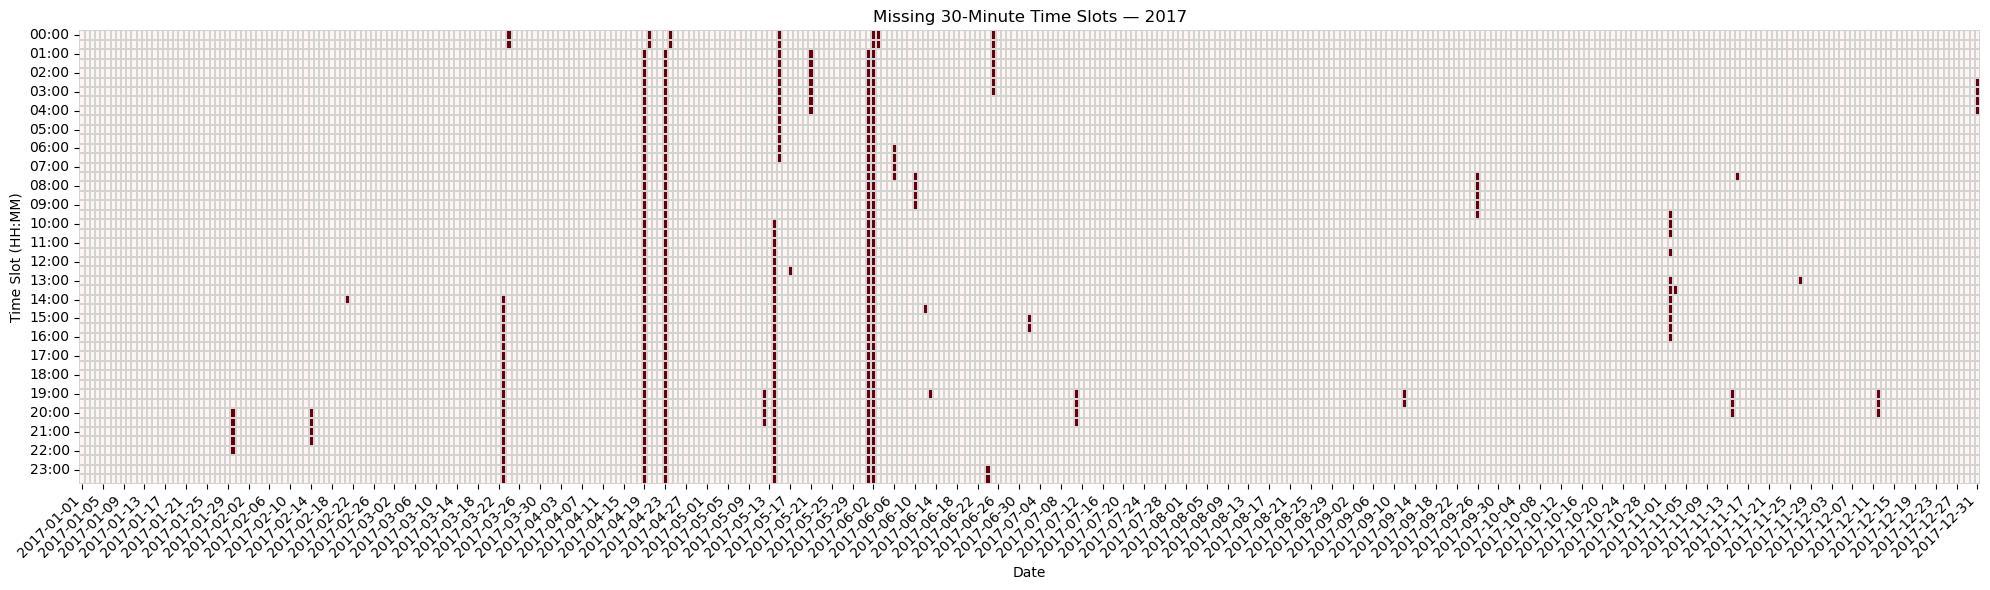

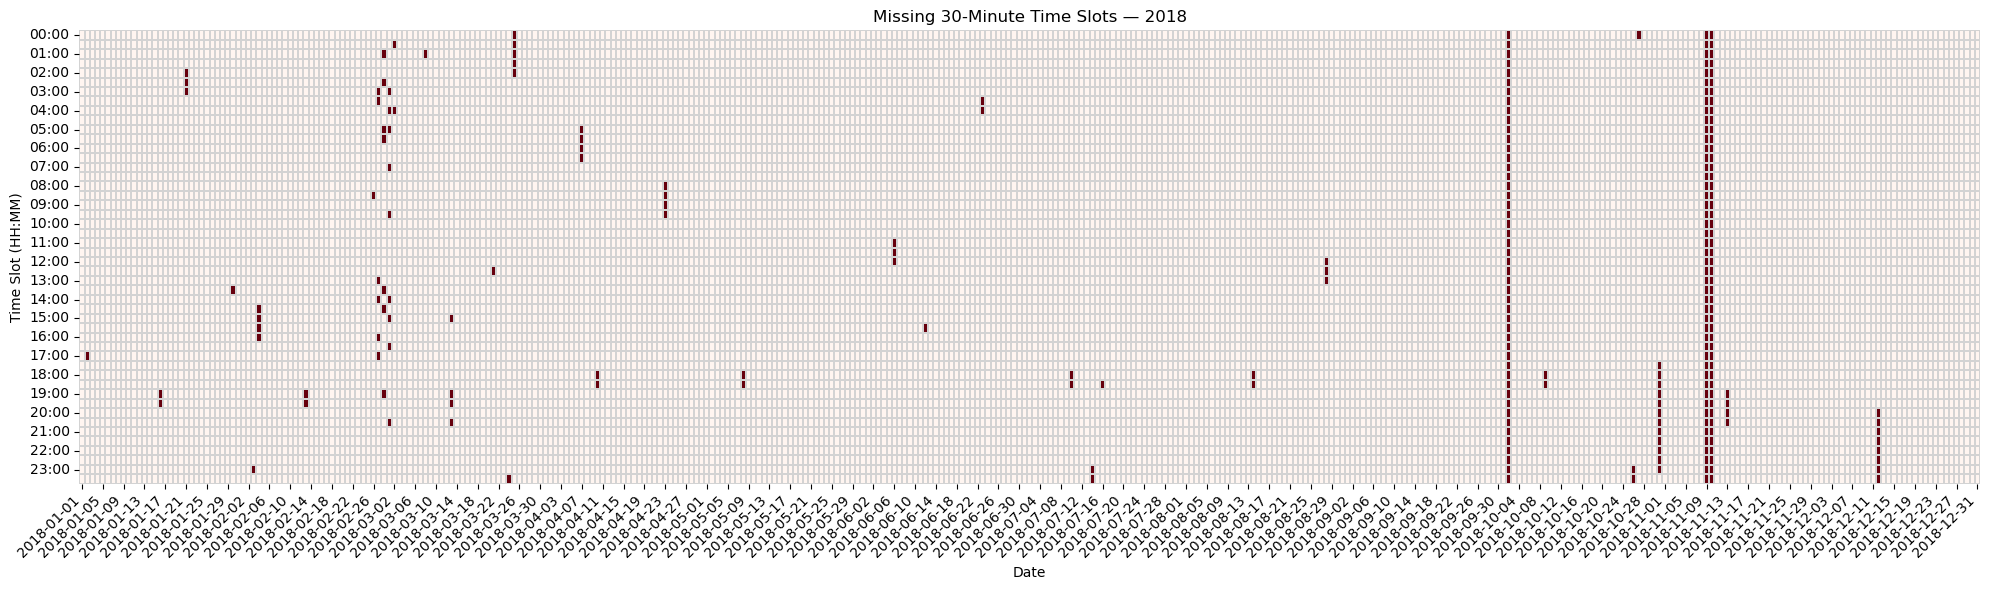

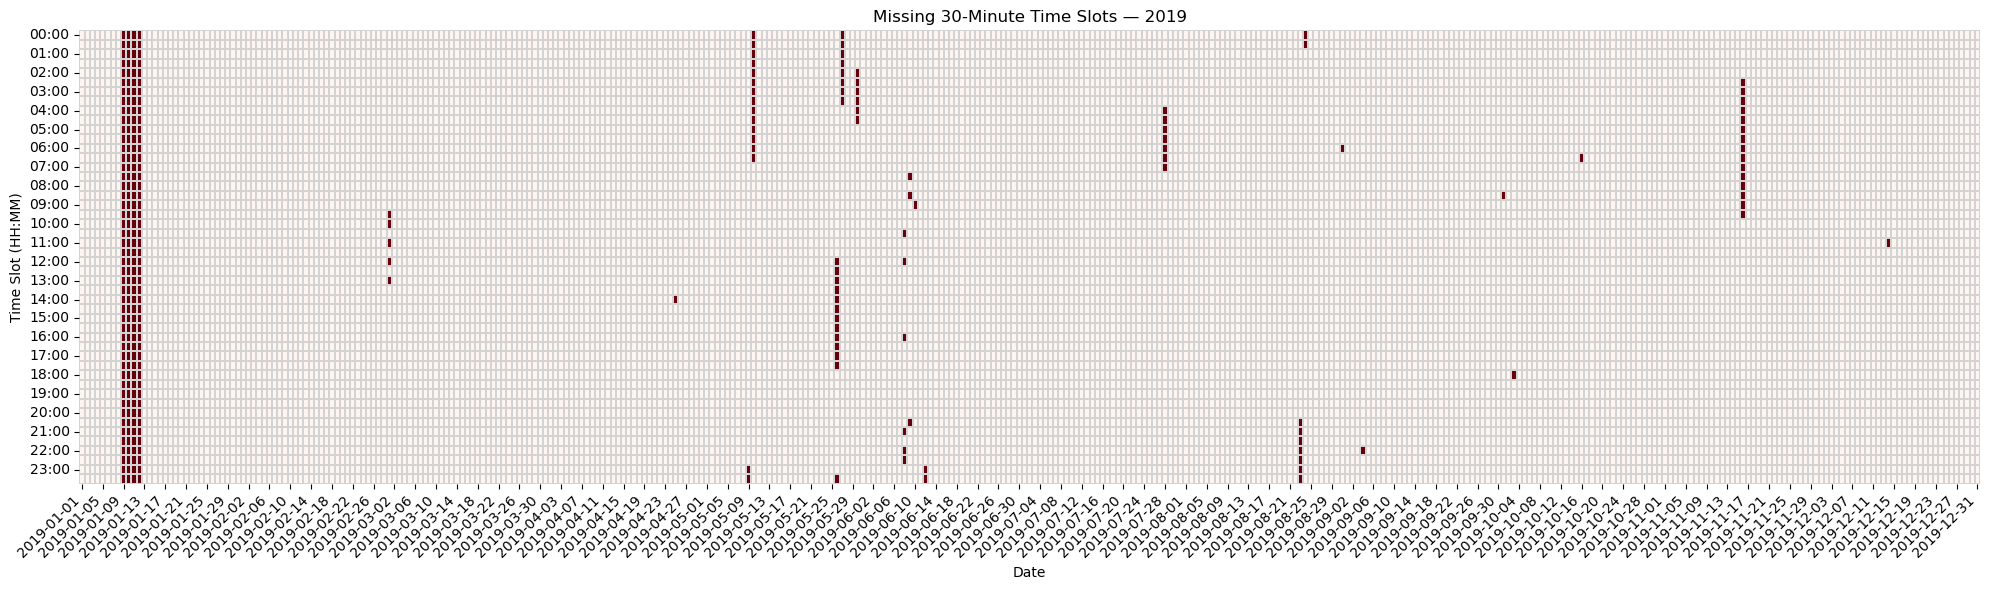

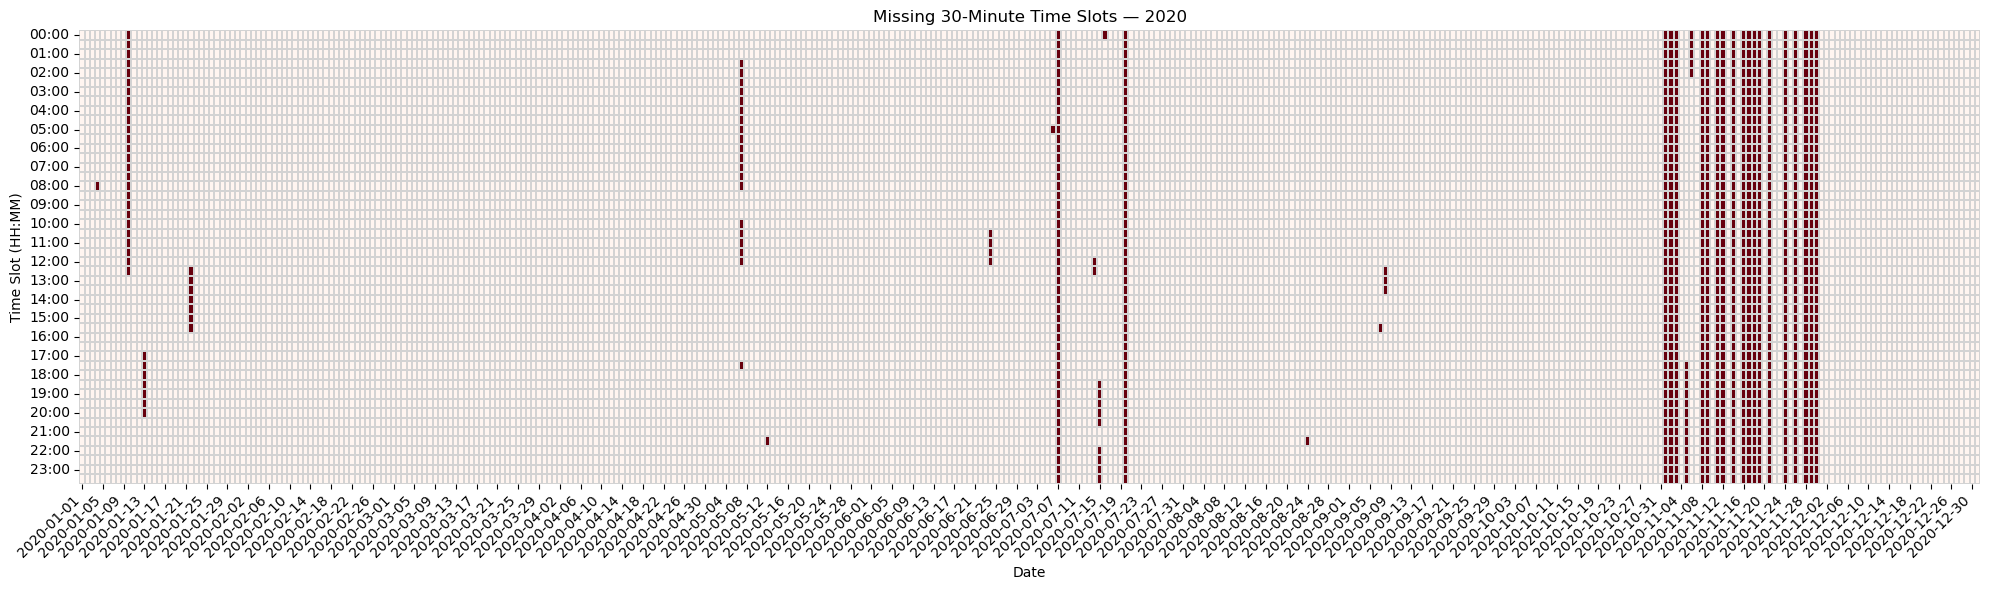

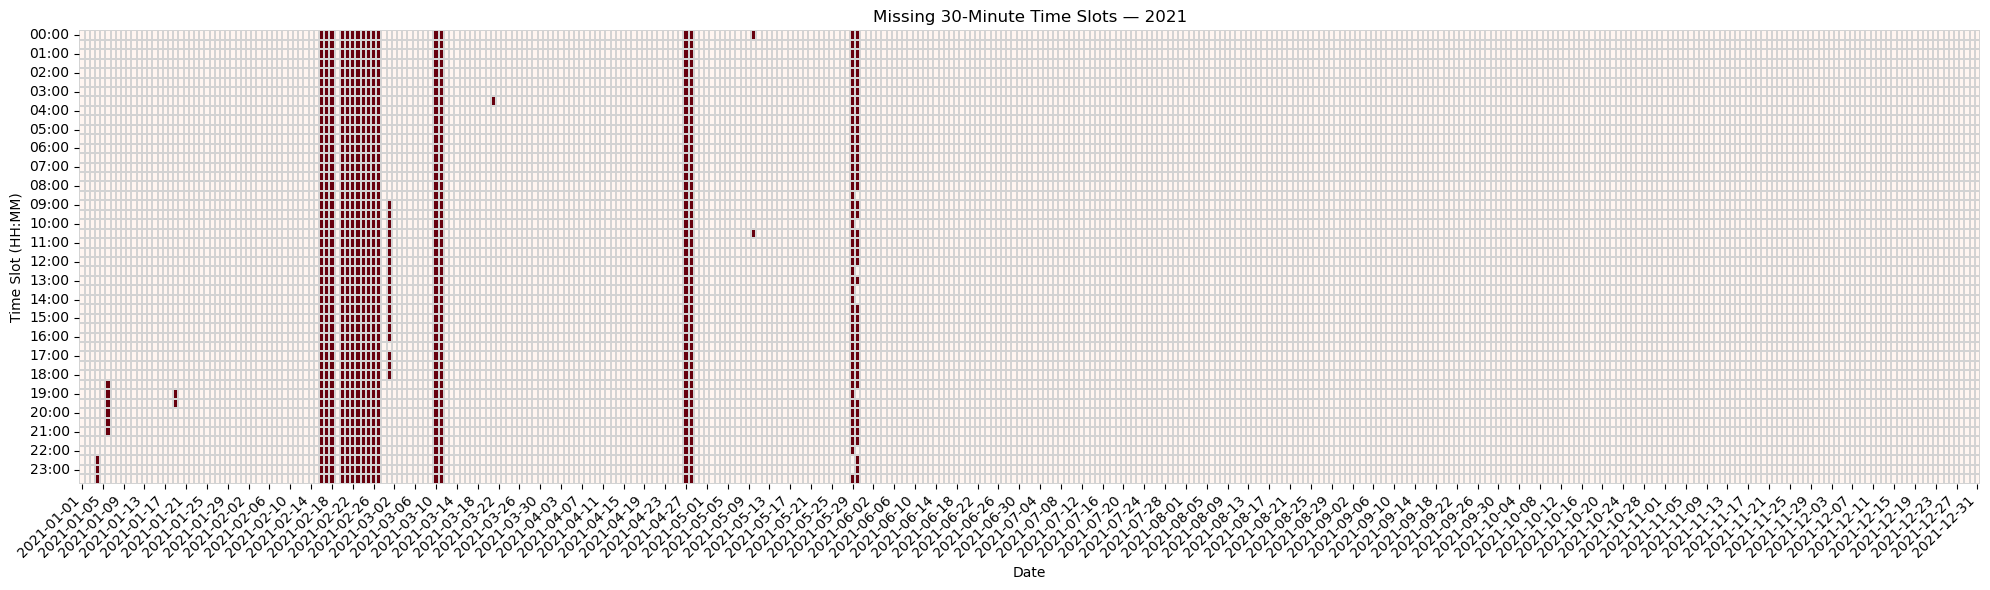

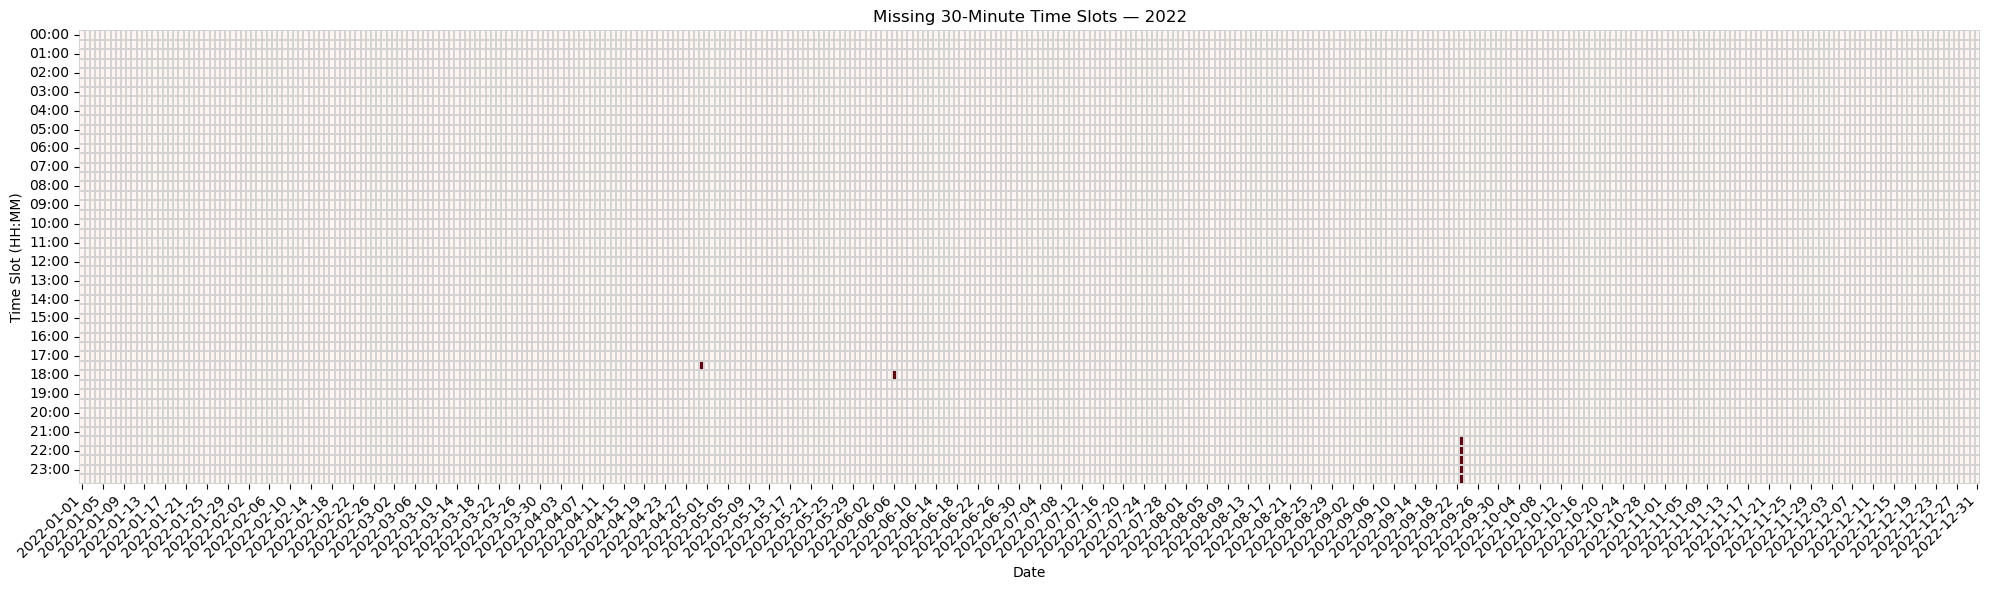

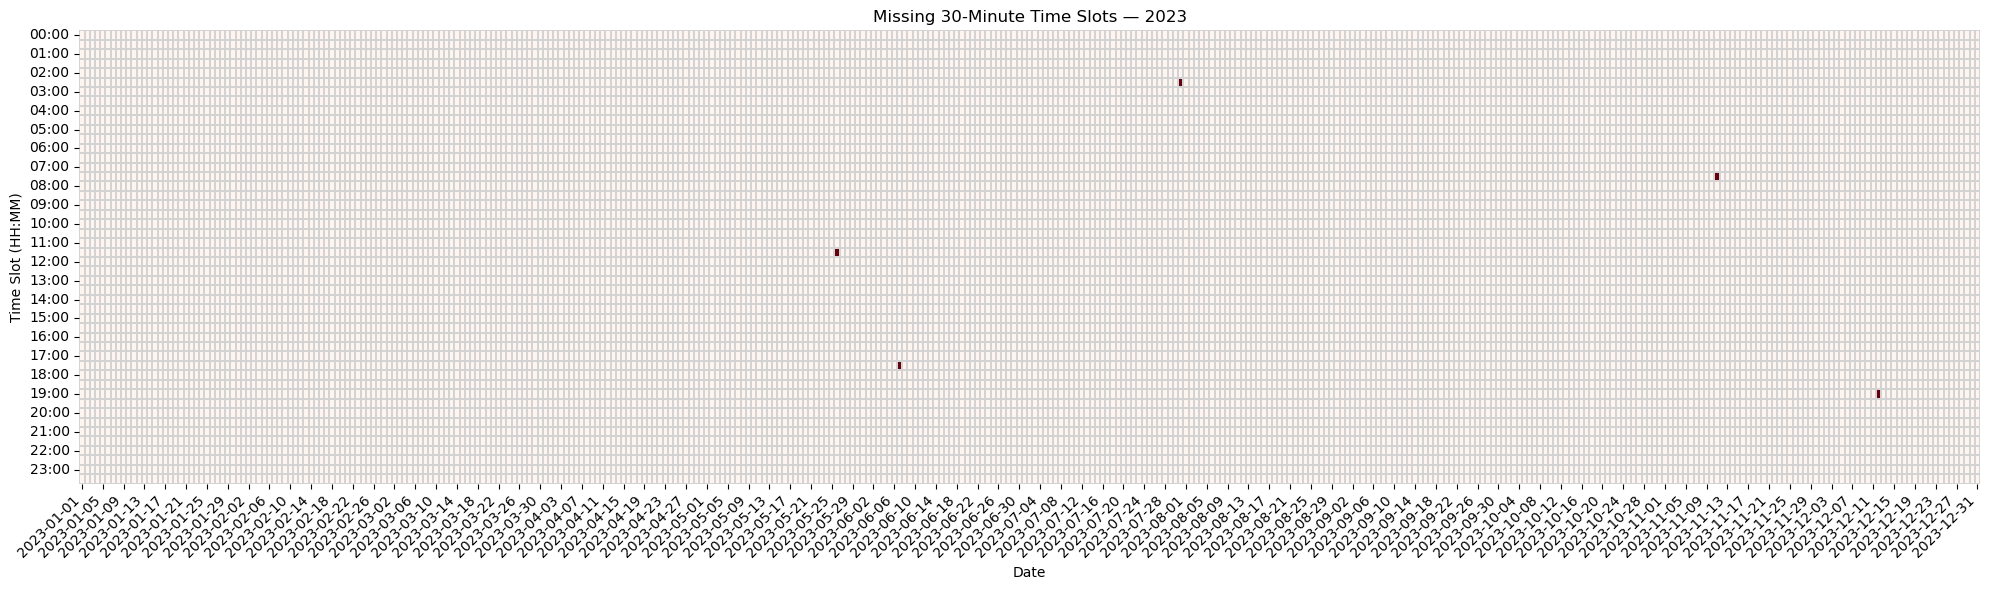

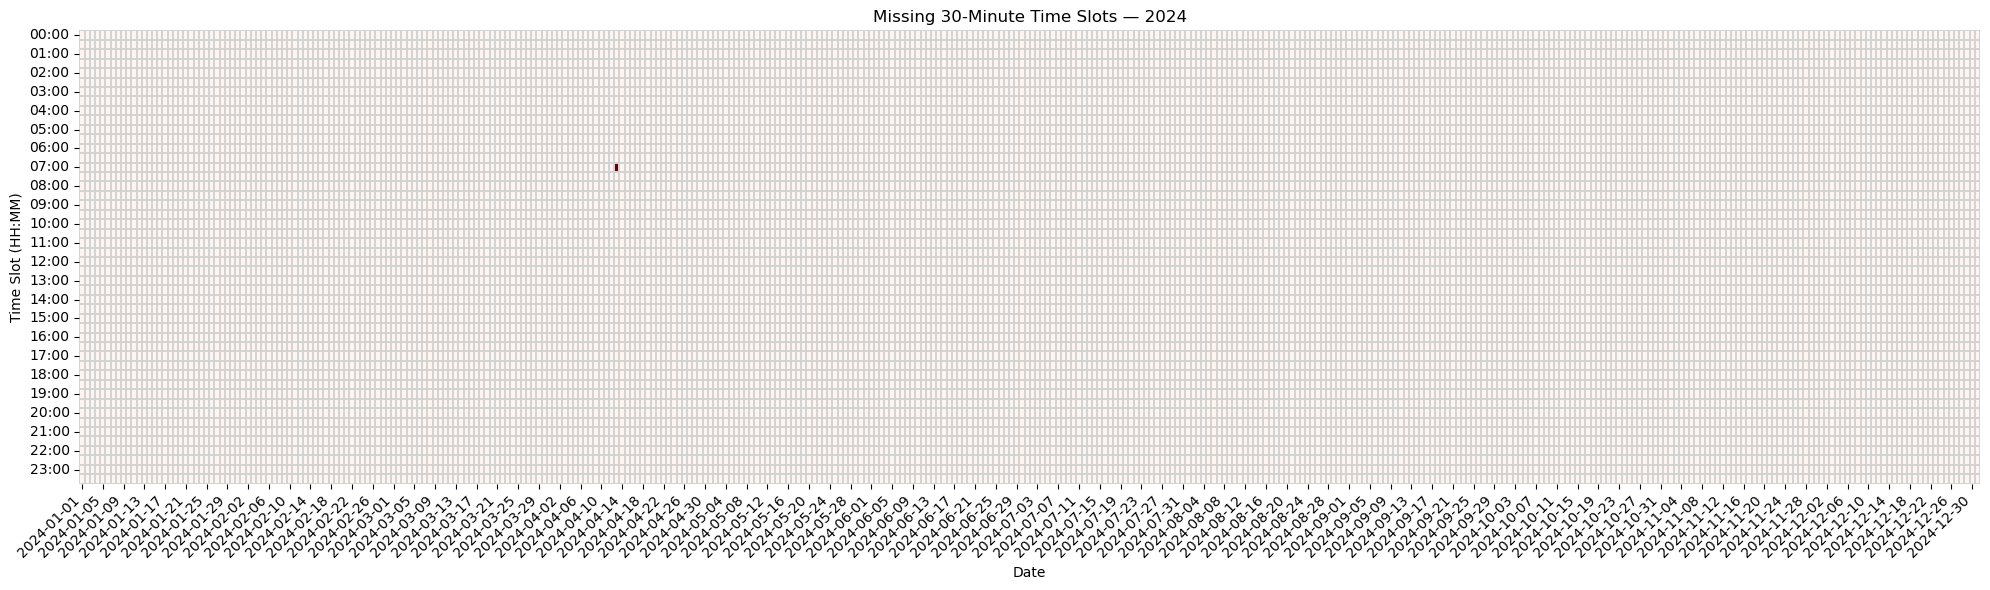

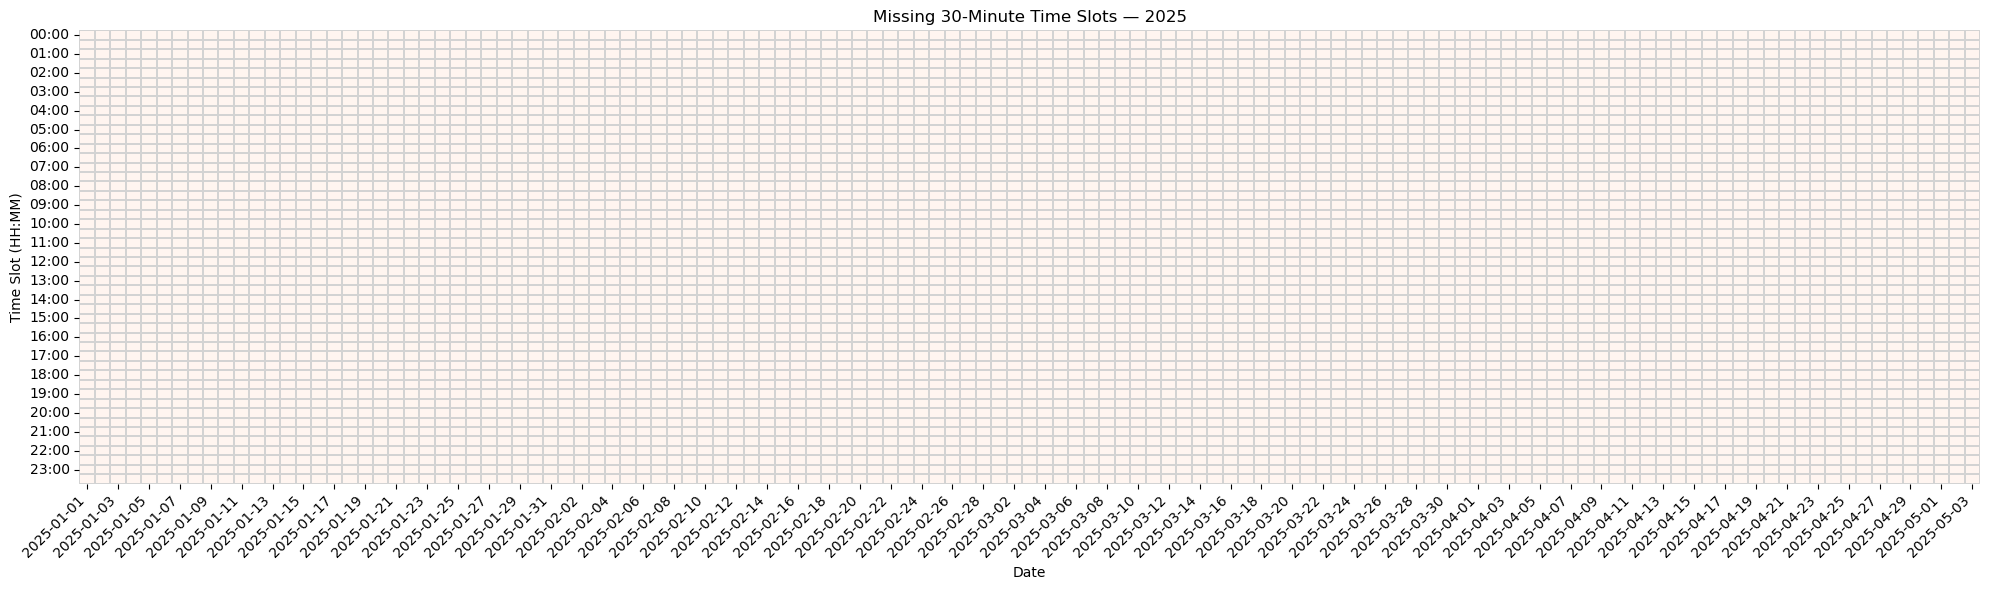

In [269]:
# Create a reference DataFrame with a complete 30-minute time series
timeline_df = pd.DataFrame({'StartTime': full_range})

# Identify which time slots are missing in combined_df
actual_times = combined_df['StartTime'].dropna().dt.round('min')
timeline_df['IsMissing'] = ~timeline_df['StartTime'].isin(actual_times)

# Extract components for heatmap visualization
timeline_df['Date'] = timeline_df['StartTime'].dt.date
timeline_df['Hour'] = timeline_df['StartTime'].dt.hour
timeline_df['Minute'] = timeline_df['StartTime'].dt.minute
timeline_df['HourSlot'] = (
    timeline_df['Hour'].astype(str).str.zfill(2) + ':' +
    timeline_df['Minute'].astype(str).str.zfill(2)
)
timeline_df['Year'] = timeline_df['StartTime'].dt.year

# Create heatmaps of missing time slots for each year
for year in sorted(timeline_df['Year'].unique()):
    df_year = timeline_df[timeline_df['Year'] == year]

    if df_year.empty:
        continue

    pivot = df_year.pivot_table(
        index='HourSlot',
        columns='Date',
        values='IsMissing',
        aggfunc='max',
        fill_value=0
    )

    plt.figure(figsize=(20, 6))
    sns.heatmap(
        pivot.astype(int),
        cmap='Reds',
        linewidths=0.2,
        linecolor='lightgray',
        vmin=0, vmax=1,
        cbar=False
    )
    plt.title(f'Missing 30-Minute Time Slots — {year}')
    plt.xlabel('Date')
    plt.ylabel('Time Slot (HH:MM)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [270]:
# Drop unnecessary columns that are no longer needed for analysis
combined_df = combined_df.drop(columns=['DataProvider', 'SettlementDate', 'SettlementPeriod', 'source_file'])

combined_df.head()

,StartTime,Price,Volume
0,2017-01-01 00:00:00+00:00,44.90,505.00
1,2017-01-01 00:30:00+00:00,47.13,559.15
2,2017-01-01 01:00:00+00:00,45.62,649.35
3,2017-01-01 01:30:00+00:00,44.05,712.65
4,2017-01-01 02:00:00+00:00,44.83,599.15


In [271]:
# Reindex the dataset to include all expected 30-minute intervals
combined_df = combined_df.set_index('StartTime').reindex(full_range)

# Rename the index to 'StartTime' to maintain consistent naming
combined_df.index.name = 'StartTime'

# Interpolate missing 'Price' and 'Volume' values using time-based interpolation
# The 'limit=12' ensures only gaps of up to 6 hours (12 × 30 minutes) are filled
combined_df['Price'] = combined_df['Price'].interpolate(method='time', limit=12)
combined_df['Volume'] = combined_df['Volume'].interpolate(method='time', limit=12)

# Reset the index
combined_df = combined_df.reset_index()

# Show the number of remaining missing values after interpolation
combined_df.isna().sum()

StartTime       0
Price        2067
Volume       2067
dtype: int64

In [272]:
# Set 'StartTime' as the index to enable time-based shifting
combined_df.set_index('StartTime', inplace=True)

# Fill remaining missing values by looking at the same time slot in the previous 1 to 7 days
# For each lag (1 to 7 days), shift the data and fill in missing values
for i in range(1, 8):  # Try up to 7 days back
    lagged = combined_df.shift(freq=f'{i}D')
    combined_df['Price'] = combined_df['Price'].fillna(lagged['Price'])
    combined_df['Volume'] = combined_df['Volume'].fillna(lagged['Volume'])

# Restore 'StartTime' as a column instead of index
combined_df = combined_df.reset_index()

# Print remaining number of missing values in 'Price' and 'Volume' after filling
print(combined_df[['Price', 'Volume']].isna().sum())

Price     0
Volume    0
dtype: int64


In [273]:
# Check the final shape of the DataFrame
combined_df.shape

(146160, 3)

In [274]:
# Print the earliest and the latest timestamps in the dataset
print("Start date:", combined_df['StartTime'].min())
print("End date:  ", combined_df['StartTime'].max())

Start date: 2017-01-01 00:00:00+00:00
End date:   2025-05-03 23:30:00+00:00


# 2. Dataset #2

## 2.1 Get the data

In [277]:
# Uses GitHub REST API to retrieve the list of .csv files in a given folder
def list_csv_files(owner, repo, folder):
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{folder}"
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request failed
    contents = response.json()
    # Filter for files that end with '.csv'
    return [item["name"] for item in contents if item["name"].endswith(".csv")]

# Set up repository and folder
owner = "tetiana-yashchenko"
repo = "Energy_Price_Cannibalisation"
base_path = "data/data_generation"

# Define folders to loop through (data_generation_1 to data_generation_5)
folders = [f"{base_path}/data_generation_{i}" for i in range(1, 6)]

dfs_generation = []

# Loop over each folder and process all .csv files found
for folder in folders:
    try:
        csv_files = list_csv_files(owner, repo, folder)
        for fname in csv_files:
            raw_url = f"https://raw.githubusercontent.com/{owner}/{repo}/main/{folder}/{fname}"
            df = pd.read_csv(raw_url)
            df["source_file"] = f"{folder}/{fname}"
            dfs_generation.append(df)
    except Exception:
        pass

# Combine all individual DataFrames into one
generation_df = pd.concat(dfs_generation, ignore_index=True)

# Print how many files were processed
print(f"Loaded {len(dfs_generation)} files.")

# Show first few rows of the final DataFrame
generation_df.head()

Loaded 435 files.


,PublishTime,BusinessType,PsrType,Quantity,StartTime,SettlementDate,SettlementPeriod,source_file
0,2017-01-08T00:58:08Z,Wind generation,Wind Onshore,1518.271,2017-01-07T23:30:00Z,2017-01-07,48,data/data_generation/data_generation_1/ActualO...
1,2017-01-08T00:58:08Z,Wind generation,Wind Offshore,315.383,2017-01-07T23:30:00Z,2017-01-07,48,data/data_generation/data_generation_1/ActualO...
2,2017-01-08T00:58:08Z,Solar generation,Solar,0.000,2017-01-07T23:30:00Z,2017-01-07,48,data/data_generation/data_generation_1/ActualO...
3,2017-01-08T00:28:09Z,Wind generation,Wind Onshore,1495.171,2017-01-07T23:00:00Z,2017-01-07,47,data/data_generation/data_generation_1/ActualO...
4,2017-01-08T00:28:09Z,Wind generation,Wind Offshore,279.857,2017-01-07T23:00:00Z,2017-01-07,47,data/data_generation/data_generation_1/ActualO...


## 2.2 Explore and clean the data

In [279]:
# Convert the 'StartTime' column to datetime format
generation_df['StartTime'] = pd.to_datetime(generation_df['StartTime'], errors='coerce')

generation_df['StartTime'].dtype

datetime64[ns, UTC]

In [280]:
# Sort the DataFrame by 'StartTime' in ascending order and reset the index
generation_df = generation_df.sort_values(by='StartTime').reset_index(drop=True)

generation_df.head()

,PublishTime,BusinessType,PsrType,Quantity,StartTime,SettlementDate,SettlementPeriod,source_file
0,2017-01-01T01:28:09Z,Solar generation,Solar,0.000,2017-01-01 00:00:00+00:00,2017-01-01,1,data/data_generation/data_generation_1/ActualO...
1,2017-01-01T01:28:09Z,Wind generation,Wind Offshore,2140.499,2017-01-01 00:00:00+00:00,2017-01-01,1,data/data_generation/data_generation_1/ActualO...
2,2017-01-01T01:28:09Z,Wind generation,Wind Onshore,2749.886,2017-01-01 00:00:00+00:00,2017-01-01,1,data/data_generation/data_generation_1/ActualO...
3,2017-01-01T01:58:09Z,Solar generation,Solar,0.000,2017-01-01 00:30:00+00:00,2017-01-01,2,data/data_generation/data_generation_1/ActualO...
4,2017-01-01T01:58:09Z,Wind generation,Wind Offshore,1842.880,2017-01-01 00:30:00+00:00,2017-01-01,2,data/data_generation/data_generation_1/ActualO...


In [281]:
# Print the shape of the DataFrame
generation_df.shape

(424797, 8)

## 2.3 Feature engineering

In [283]:
# Select only the relevant columns from the DataFrame
generation_df = generation_df[['BusinessType', 'PsrType', 'Quantity', 'StartTime']]

generation_df.head()

,BusinessType,PsrType,Quantity,StartTime
0,Solar generation,Solar,0.000,2017-01-01 00:00:00+00:00
1,Wind generation,Wind Offshore,2140.499,2017-01-01 00:00:00+00:00
2,Wind generation,Wind Onshore,2749.886,2017-01-01 00:00:00+00:00
3,Solar generation,Solar,0.000,2017-01-01 00:30:00+00:00
4,Wind generation,Wind Offshore,1842.880,2017-01-01 00:30:00+00:00


In [284]:
# Pivot the generation data to summarize total Quantity by StartTime and PsrType
pivot_df = generation_df.pivot_table(
    index='StartTime',
    columns='PsrType',
    values='Quantity',
    aggfunc='sum'
).reset_index()

In [285]:
pivot_df.head()

PsrType,StartTime,Solar,Wind Offshore,Wind Onshore
0,2017-01-01 00:00:00+00:00,0.0,2140.499,2749.886
1,2017-01-01 00:30:00+00:00,0.0,1842.880,2752.310
2,2017-01-01 01:00:00+00:00,0.0,2076.755,2608.754
3,2017-01-01 01:30:00+00:00,0.0,2566.095,2873.248
4,2017-01-01 02:00:00+00:00,0.0,2390.259,3010.469


In [286]:
# Check the shape of the DataFrame
print(pivot_df.shape)

(140979, 4)


In [287]:
# Create a complete datetime range covering the entire generation data period
full_range_generation = pd.date_range(
    start=pivot_df['StartTime'].min(),
    end=pivot_df['StartTime'].max(),
    freq='30min',
    tz='UTC'
)

In [288]:
# Extract and sort unique timestamps from the generation data
actual_times_generation = pivot_df['StartTime'].drop_duplicates().sort_values()

# Identify timestamps in the full expected range that are missing from the actual data
missing_times_generation = full_range_generation.difference(actual_times_generation)

print(f"Total missing time slots: {len(missing_times_generation)}")
print(missing_times_generation)

Total missing time slots: 5181
DatetimeIndex(['2017-01-01 23:00:00+00:00', '2017-01-02 04:30:00+00:00',
               '2017-01-03 01:00:00+00:00', '2017-01-04 17:00:00+00:00',
               '2017-01-10 04:30:00+00:00', '2017-01-12 23:30:00+00:00',
               '2017-01-16 03:00:00+00:00', '2017-01-20 11:00:00+00:00',
               '2017-01-20 16:00:00+00:00', '2017-01-22 20:00:00+00:00',
               ...
               '2025-04-03 20:30:00+00:00', '2025-04-05 15:00:00+00:00',
               '2025-04-05 15:30:00+00:00', '2025-04-05 16:00:00+00:00',
               '2025-04-05 22:00:00+00:00', '2025-04-05 23:00:00+00:00',
               '2025-04-05 23:30:00+00:00', '2025-04-06 00:00:00+00:00',
               '2025-04-28 19:00:00+00:00', '2025-04-29 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=5181, freq=None)


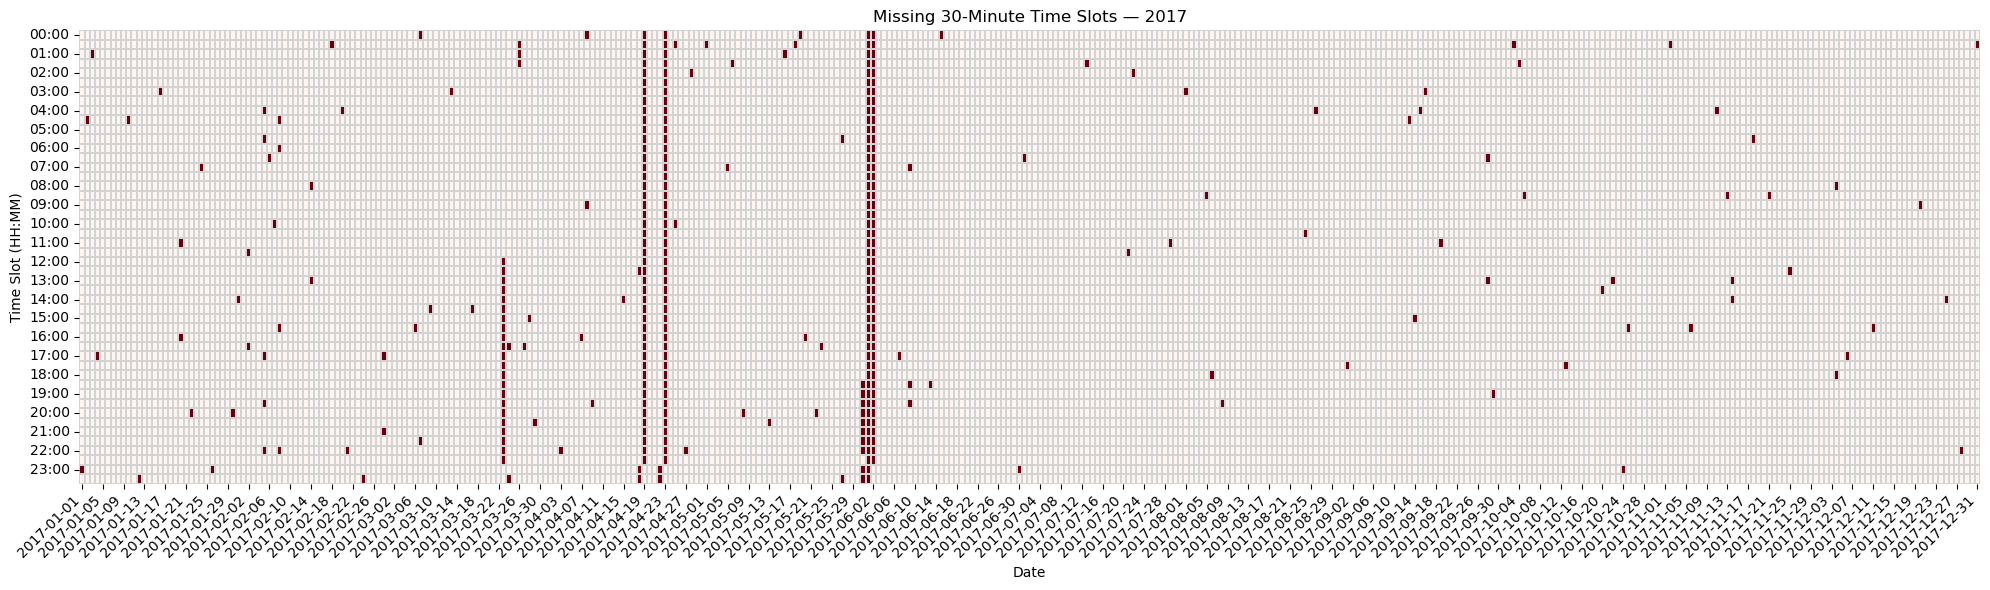

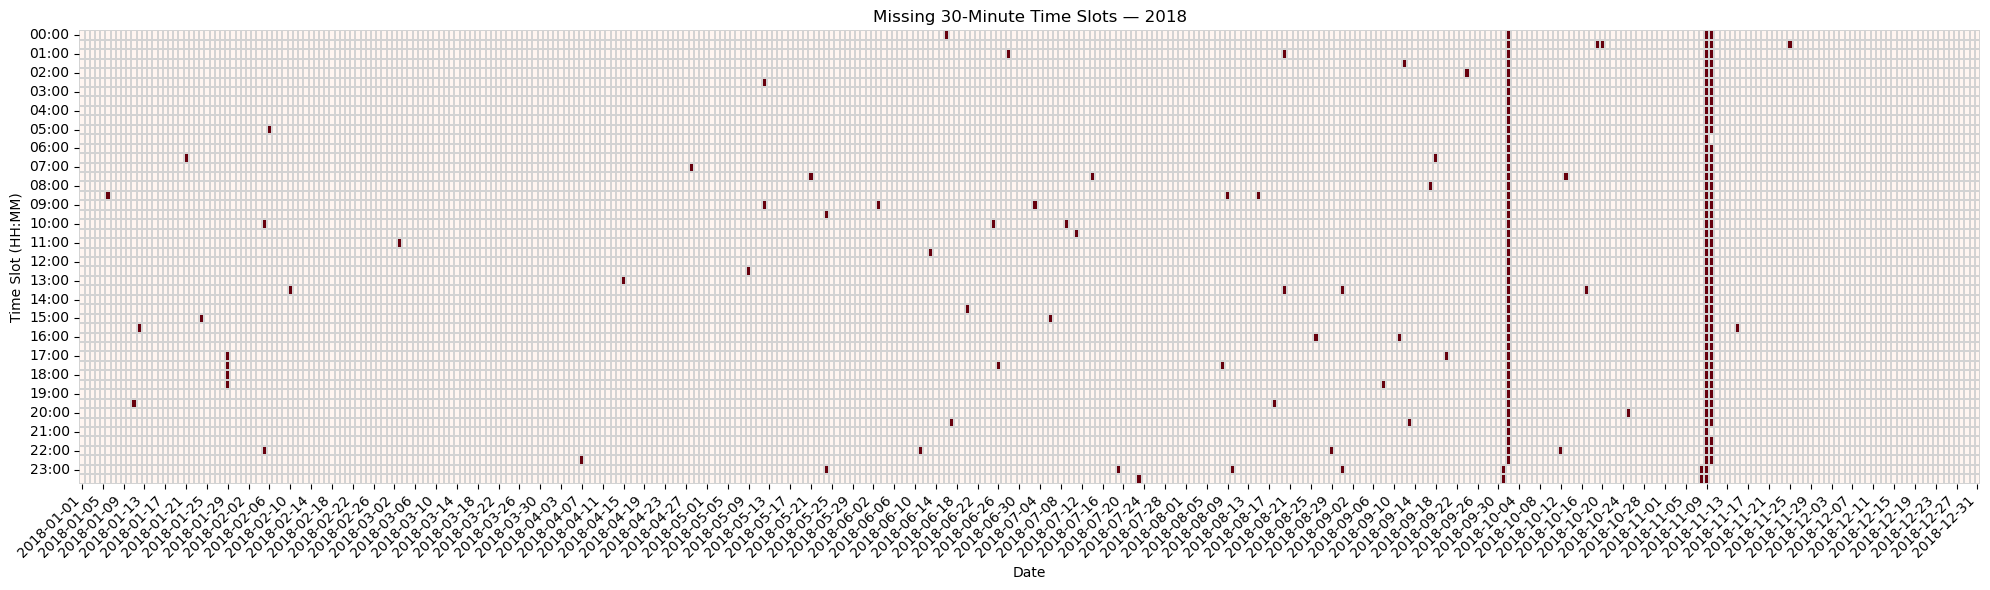

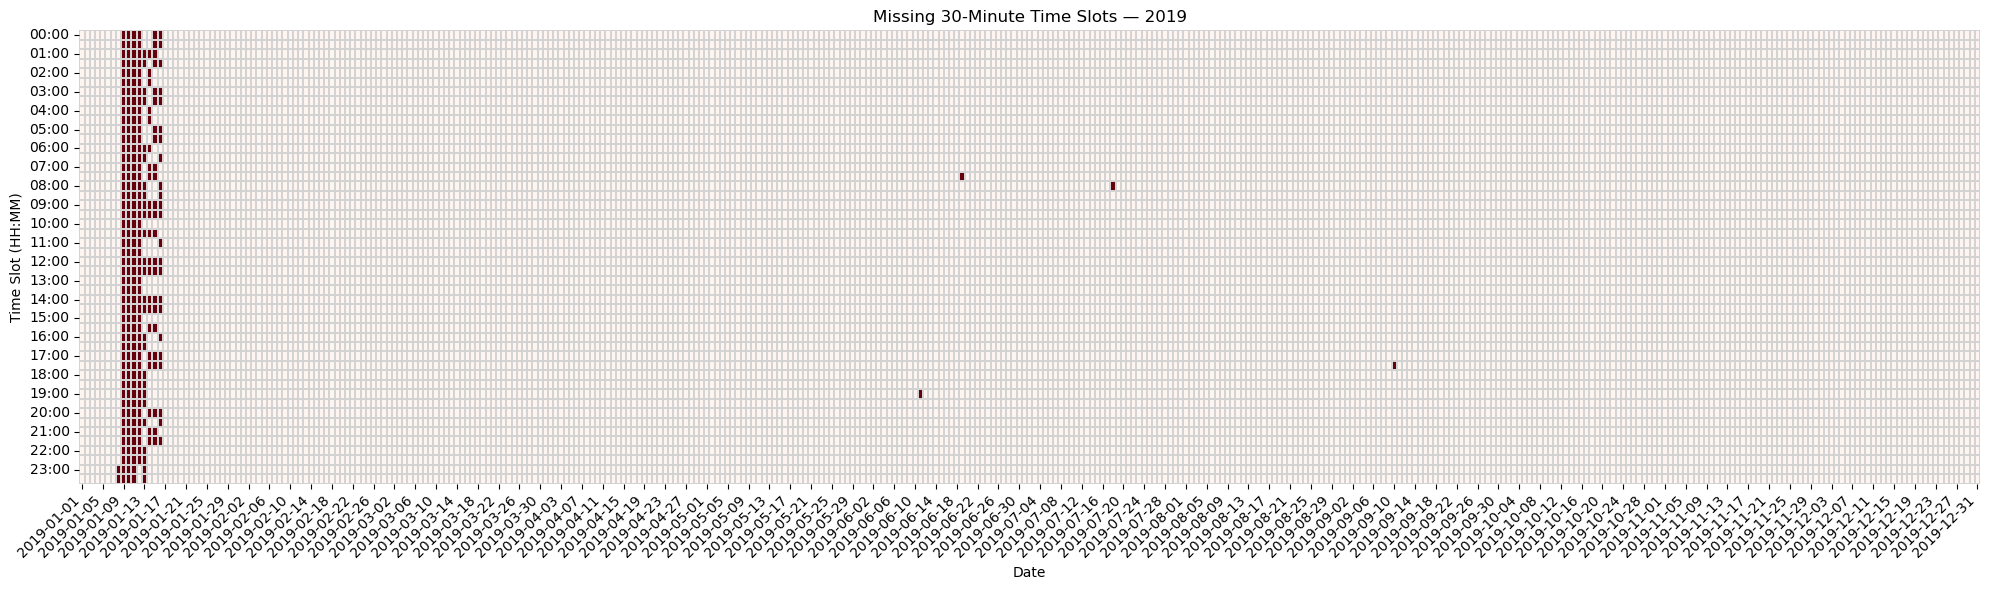

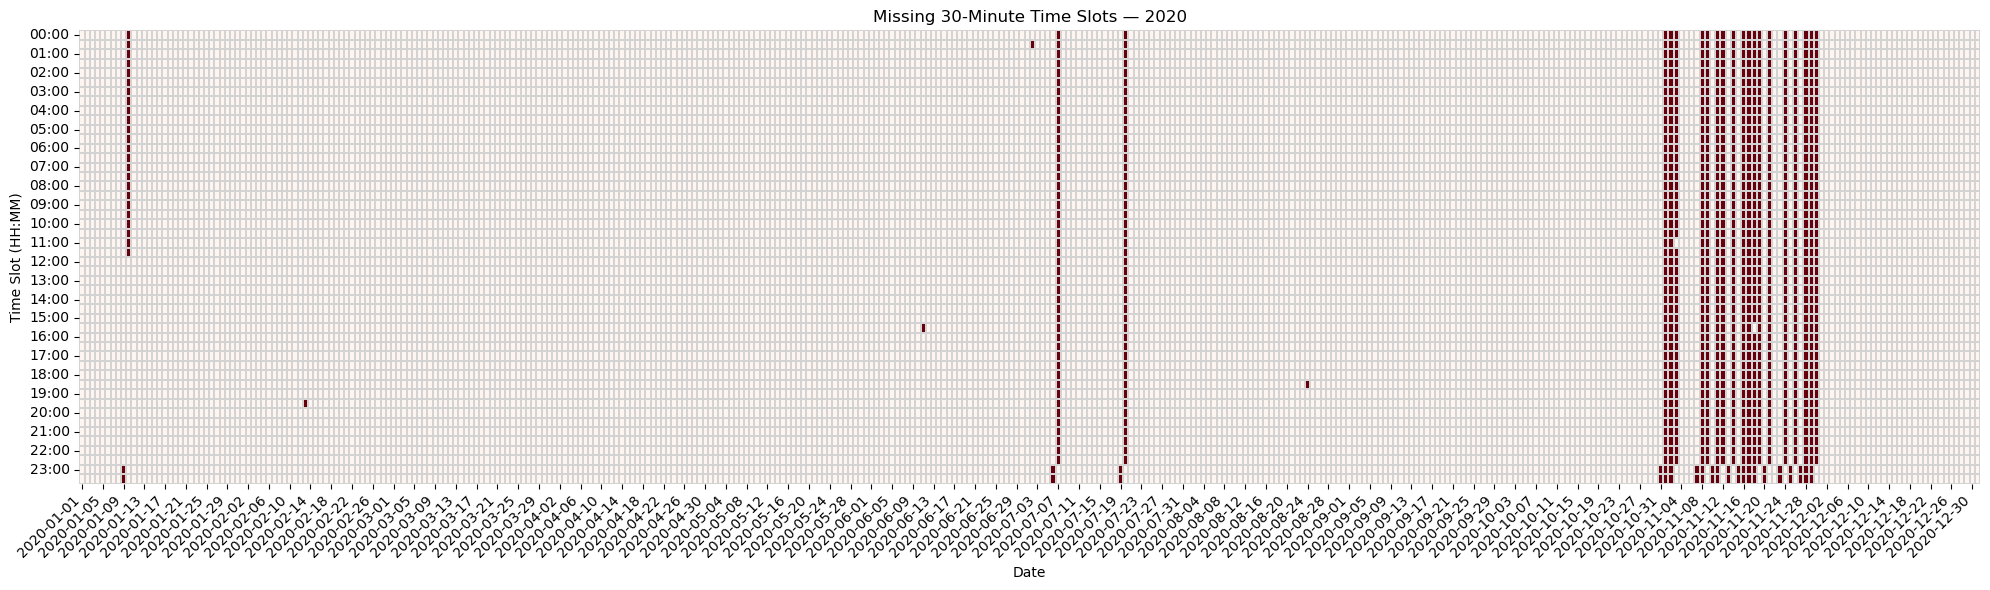

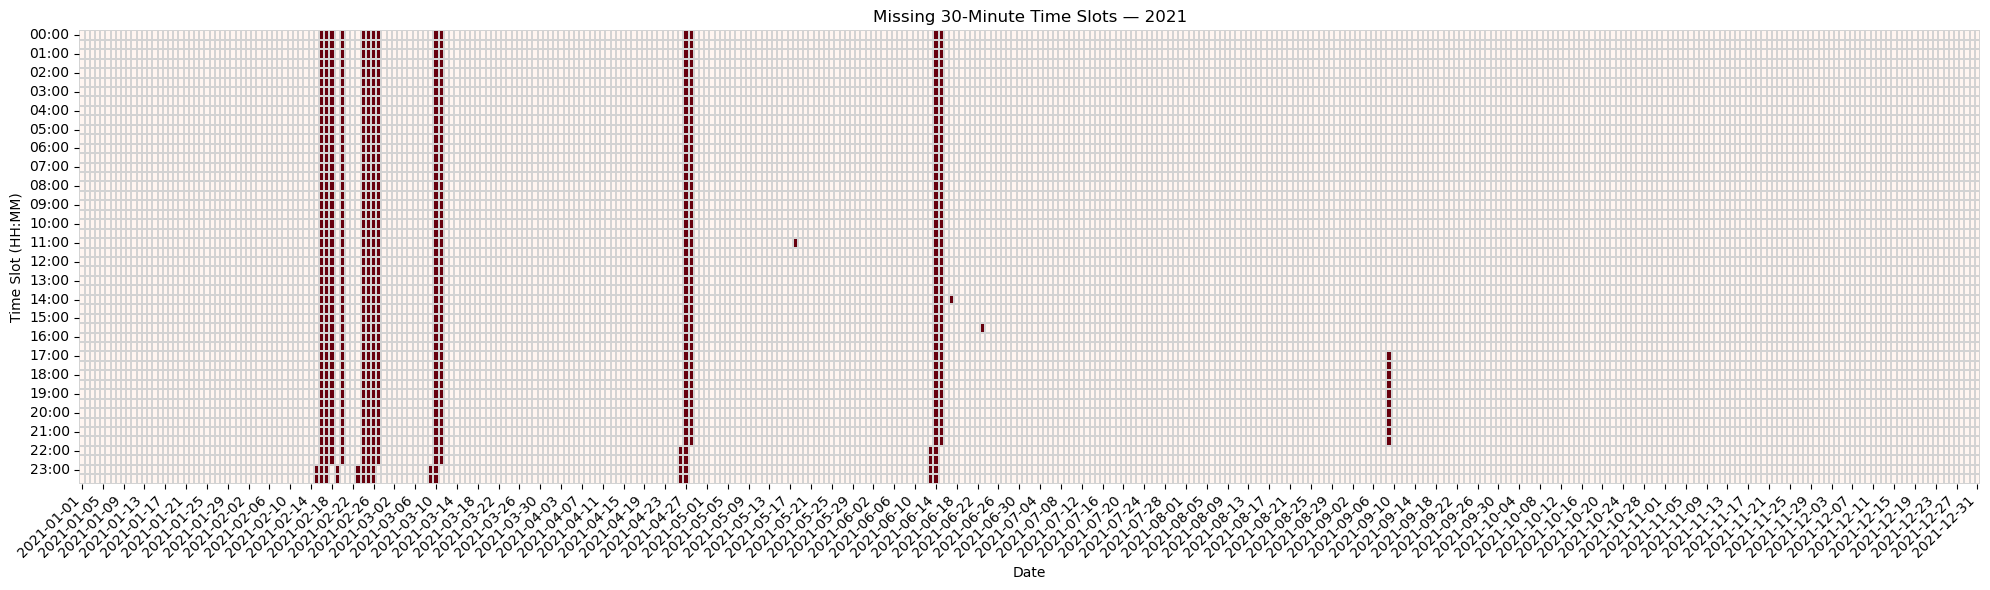

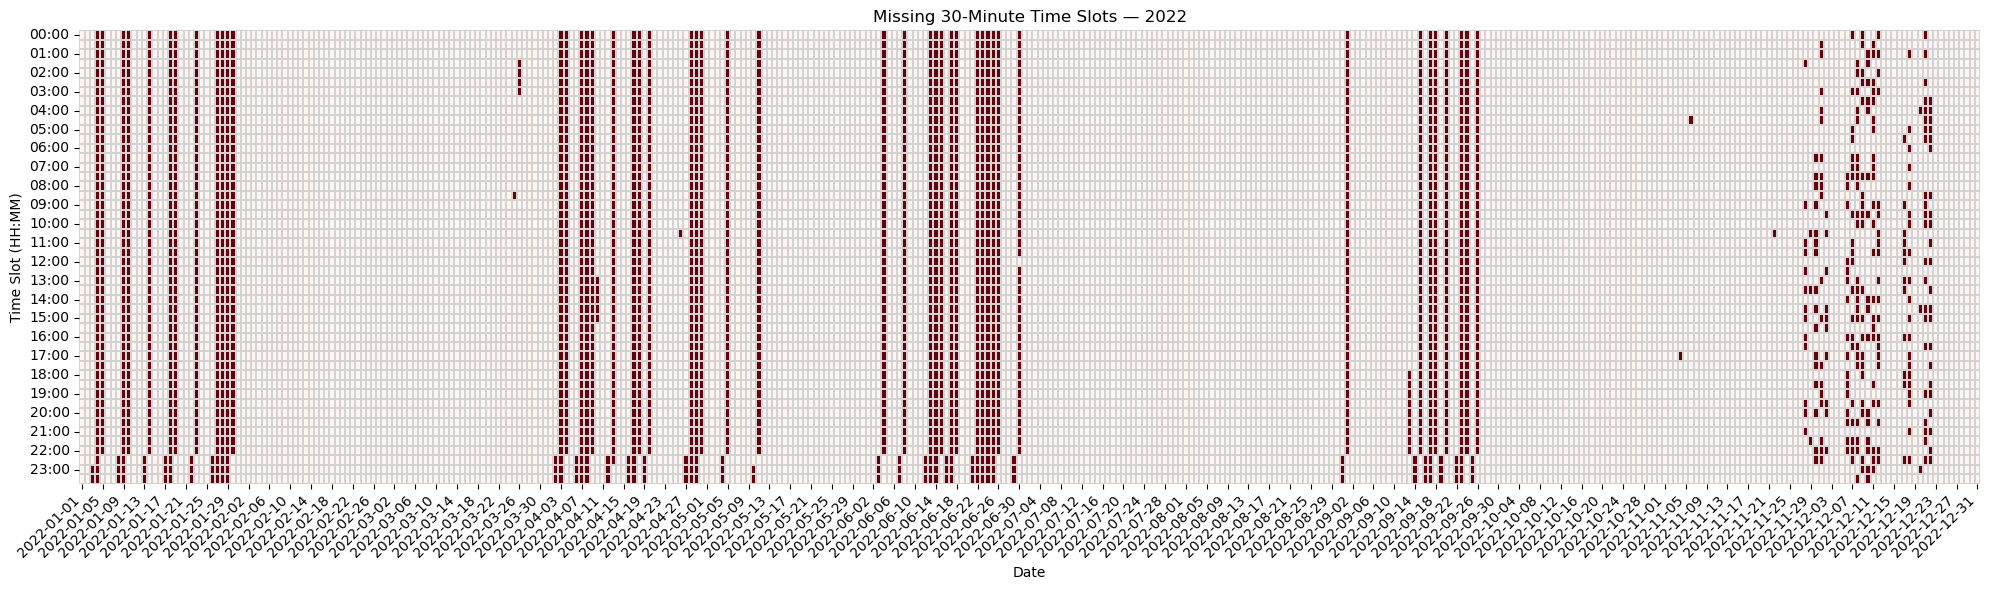

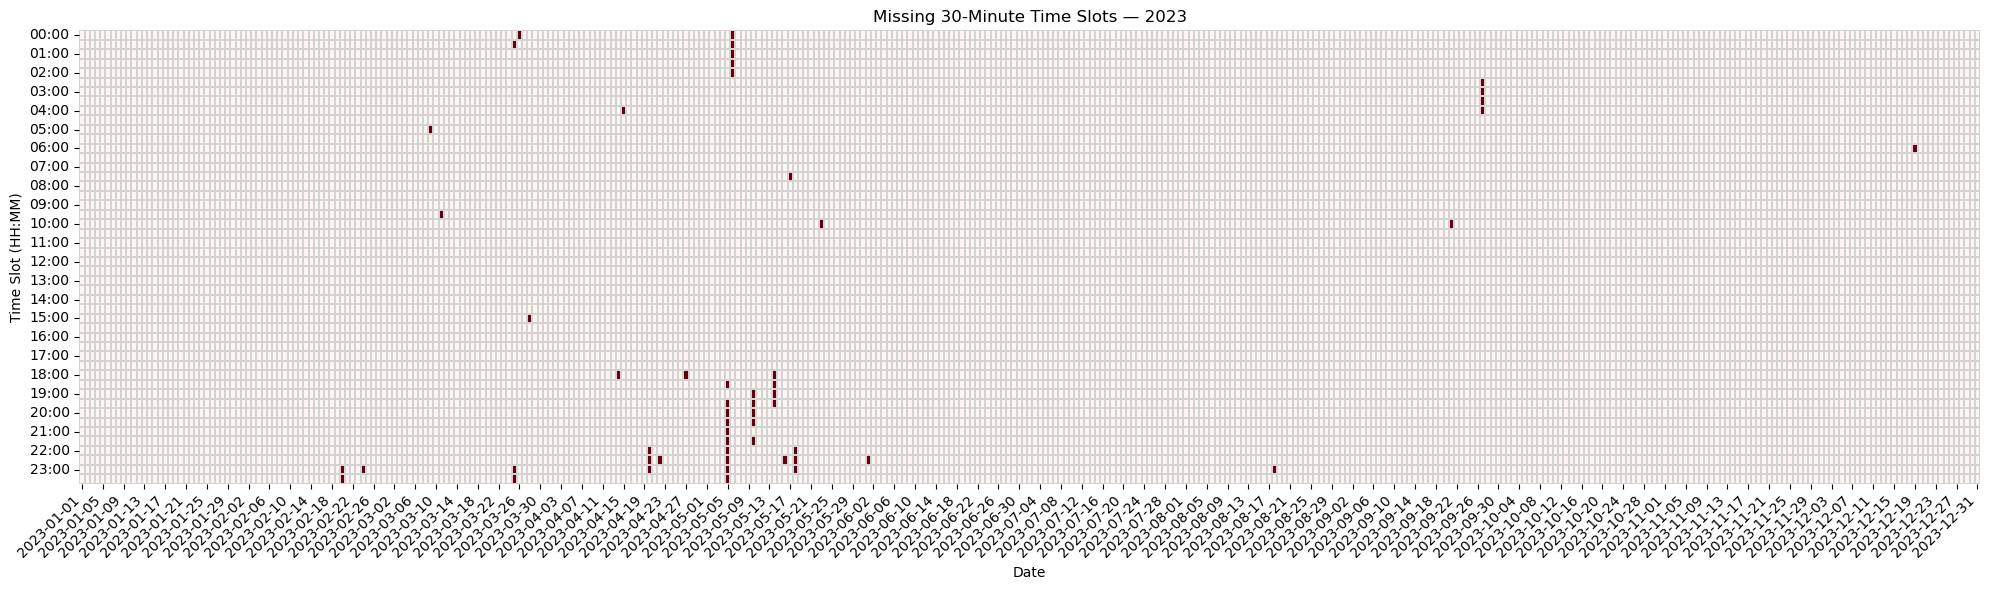

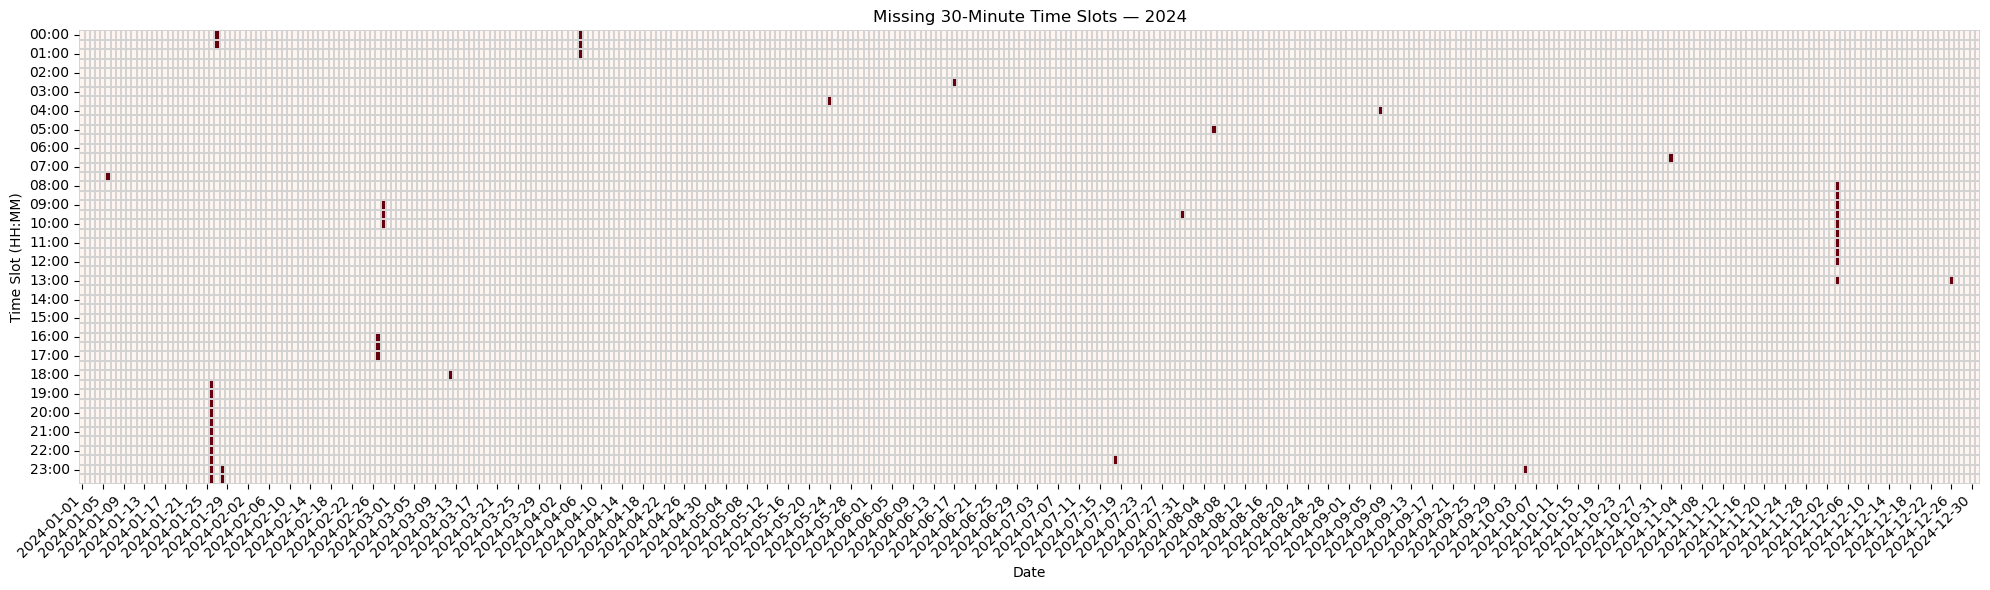

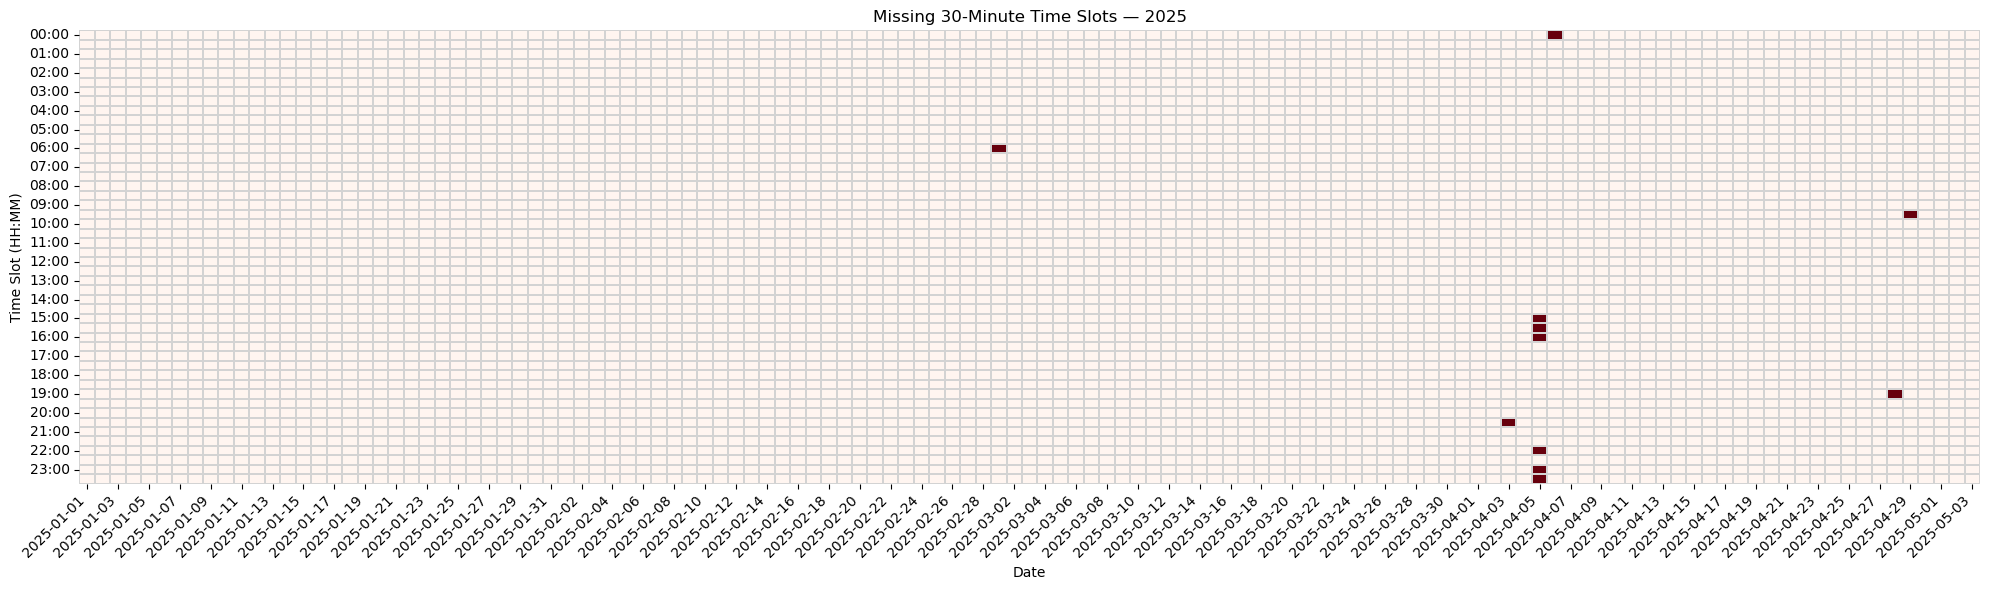

In [289]:
# Build a full timeline DataFrame for the generation data
timeline_df_generation = pd.DataFrame({'StartTime': full_range_generation})

# Mark missing time slots
actual_times_generation = pivot_df['StartTime'].dt.round('min')
timeline_df_generation['IsMissing'] = ~timeline_df_generation['StartTime'].isin(actual_times_generation)

# Extract datetime components for plotting
timeline_df_generation['Date'] = timeline_df_generation['StartTime'].dt.date
timeline_df_generation['Hour'] = timeline_df_generation['StartTime'].dt.hour
timeline_df_generation['Minute'] = timeline_df_generation['StartTime'].dt.minute
timeline_df_generation['HourSlot'] = (
    timeline_df_generation['Hour'].astype(str).str.zfill(2) + ':' +
    timeline_df_generation['Minute'].astype(str).str.zfill(2)
)
timeline_df_generation['Year'] = timeline_df_generation['StartTime'].dt.year

# Plot missing data as a heatmap for each year
for year in sorted(timeline_df_generation['Year'].unique()):
    df_year = timeline_df_generation[timeline_df_generation['Year'] == year]

    if df_year.empty:
        continue

    pivot_missing = df_year.pivot_table(
        index='HourSlot',
        columns='Date',
        values='IsMissing',
        aggfunc='max',
        fill_value=0
    )

    plt.figure(figsize=(20, 6))
    sns.heatmap(
        pivot_missing.astype(int),
        cmap='Reds',
        linewidths=0.2,
        linecolor='lightgray',
        vmin=0,
        vmax=1,
        cbar=False
    )
    plt.title(f'Missing 30-Minute Time Slots — {year}')
    plt.xlabel('Date')
    plt.ylabel('Time Slot (HH:MM)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [290]:
# Count missing values
for col in ['Solar', 'Wind Offshore', 'Wind Onshore']:
    num_missing = pivot_df[col].isna().sum()
    print(f"Missing values in '{col}': {num_missing}")

Missing values in 'Solar': 0
Missing values in 'Wind Offshore': 0
Missing values in 'Wind Onshore': 0


In [291]:
# Reindex the pivoted DataFrame to ensure it includes all expected 30-minute intervals 
pivot_df = pivot_df.set_index('StartTime').reindex(full_range_generation)
pivot_df.index.name = 'StartTime'

In [292]:
# Fill short gaps (up to 6 hours = 12 intervals)
pivot_df['Solar'] = pivot_df['Solar'].interpolate(method='time', limit=12)
pivot_df['Wind Offshore'] = pivot_df['Wind Offshore'].interpolate(method='time', limit=12)
pivot_df['Wind Onshore'] = pivot_df['Wind Onshore'].interpolate(method='time', limit=12)

In [293]:
# Fill remaining missing values by backfilling with the same time slot from up to 7 previous days
for i in range(1, 8):  # 1 to 7 days back
    lagged = pivot_df.shift(freq=f'{i}D')
    for col in ['Solar', 'Wind Offshore', 'Wind Onshore']:
        pivot_df[col] = pivot_df[col].fillna(lagged[col])

In [294]:
# Reset the index
pivot_df = pivot_df.reset_index()

In [295]:
# Count the number of remaining missing values in each column
pivot_df.isna().sum()

PsrType
StartTime        0
Solar            0
Wind Offshore    0
Wind Onshore     0
dtype: int64

In [296]:
# Check the shape of the DataFrame
pivot_df.shape

(146160, 4)

In [297]:
# Display the start and end timestamps of the time series
print("Start:", pivot_df['StartTime'].min())
print("End:  ", pivot_df['StartTime'].max())

Start: 2017-01-01 00:00:00+00:00
End:   2025-05-03 23:30:00+00:00


In [298]:
# Make sure both StartTime columns are datetime and timezone-aware
combined_df['StartTime'] = pd.to_datetime(combined_df['StartTime'], utc=True)
pivot_df['StartTime'] = pd.to_datetime(pivot_df['StartTime'], utc=True)

# Merge on StartTime
final_df = pd.merge(combined_df, pivot_df, on='StartTime', how='inner')

# Confirm structure
print(final_df.shape)
final_df.head()

(146160, 6)


,StartTime,Price,Volume,Solar,Wind Offshore,Wind Onshore
0,2017-01-01 00:00:00+00:00,44.90,505.00,0.0,2140.499,2749.886
1,2017-01-01 00:30:00+00:00,47.13,559.15,0.0,1842.880,2752.310
2,2017-01-01 01:00:00+00:00,45.62,649.35,0.0,2076.755,2608.754
3,2017-01-01 01:30:00+00:00,44.05,712.65,0.0,2566.095,2873.248
4,2017-01-01 02:00:00+00:00,44.83,599.15,0.0,2390.259,3010.469


# 3. Dataset #3

## 3.1 Get the data

In [301]:
# https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview

In [302]:
# Google Drive file IDs for .nc files
nc_file_ids = [
    "1ll4V1rjhg6qKixc-vMR0Z58KpQIMf9vl",
    "1cycEON_SZwZbufrk4sAEMaYgSc_52B1c",
    "10vggN1ct--WNQJbhjbSMe1ZjH-zA5fvo",
    "1l-2hyKOpxWFFmFO-IbCqS847i6-28V2E",
    "1c9VtIP9WcL5CgIP1aF1JfyM9Ip0rqArC",
    "1_jRiv3MUsXJAvBJwSSBzTVn8oowWf7LC",
    "1ZDyOig-6gZRtzZ-HGyumZElM1q0CN4aR",
    "17qs2MKCUYoF_5F769K0yO_MRIKQza5oI",
    "1F4FTQjWvJFJN_NiELfg0IMNEGiuWfRuo"
]

# List to store processed DataFrames
all_dfs = []

# Loop through each file
for file_id in nc_file_ids:
    filename = f"{file_id}.nc"
    
    print(f"Processing: {filename}")
    gdown.download(id=file_id, output=filename, quiet=False)

    ds = xr.open_dataset(filename, engine="netcdf4")
    solar = ds['ssrd']

    df = (
        solar.to_dataframe()
        .reset_index()
        .groupby('valid_time')['ssrd']
        .sum()
        .reset_index()
        .rename(columns={'valid_time': 'datetime', 'ssrd': 'solar_radiation'})
    )

    all_dfs.append(df)

# Combine all DataFrames into one
df_solar = pd.concat(all_dfs, ignore_index=True)

# Preview
print("Final shape:", df_solar.shape)
print(df_solar.head())
print("Date range:", df_solar['datetime'].min(), "→", df_solar['datetime'].max())

Processing: 1ll4V1rjhg6qKixc-vMR0Z58KpQIMf9vl.nc


Downloading...
From: https://drive.google.com/uc?id=1ll4V1rjhg6qKixc-vMR0Z58KpQIMf9vl
To: /Users/tetiana.yachtchenko/1ll4V1rjhg6qKixc-vMR0Z58KpQIMf9vl.nc
100%|██████████████████████████████████████| 31.8M/31.8M [00:03<00:00, 8.28MB/s]


Processing: 1cycEON_SZwZbufrk4sAEMaYgSc_52B1c.nc


Downloading...
From: https://drive.google.com/uc?id=1cycEON_SZwZbufrk4sAEMaYgSc_52B1c
To: /Users/tetiana.yachtchenko/1cycEON_SZwZbufrk4sAEMaYgSc_52B1c.nc
100%|██████████████████████████████████████| 31.9M/31.9M [00:03<00:00, 7.99MB/s]


Processing: 10vggN1ct--WNQJbhjbSMe1ZjH-zA5fvo.nc


Downloading...
From: https://drive.google.com/uc?id=10vggN1ct--WNQJbhjbSMe1ZjH-zA5fvo
To: /Users/tetiana.yachtchenko/10vggN1ct--WNQJbhjbSMe1ZjH-zA5fvo.nc
100%|██████████████████████████████████████| 11.5M/11.5M [00:01<00:00, 8.95MB/s]


Processing: 1l-2hyKOpxWFFmFO-IbCqS847i6-28V2E.nc


Downloading...
From: https://drive.google.com/uc?id=1l-2hyKOpxWFFmFO-IbCqS847i6-28V2E
To: /Users/tetiana.yachtchenko/1l-2hyKOpxWFFmFO-IbCqS847i6-28V2E.nc
100%|██████████████████████████████████████| 31.9M/31.9M [00:04<00:00, 7.11MB/s]


Processing: 1c9VtIP9WcL5CgIP1aF1JfyM9Ip0rqArC.nc


Downloading...
From: https://drive.google.com/uc?id=1c9VtIP9WcL5CgIP1aF1JfyM9Ip0rqArC
To: /Users/tetiana.yachtchenko/1c9VtIP9WcL5CgIP1aF1JfyM9Ip0rqArC.nc
100%|██████████████████████████████████████| 32.5M/32.5M [00:04<00:00, 8.00MB/s]


Processing: 1_jRiv3MUsXJAvBJwSSBzTVn8oowWf7LC.nc


Downloading...
From: https://drive.google.com/uc?id=1_jRiv3MUsXJAvBJwSSBzTVn8oowWf7LC
To: /Users/tetiana.yachtchenko/1_jRiv3MUsXJAvBJwSSBzTVn8oowWf7LC.nc
100%|██████████████████████████████████████| 32.3M/32.3M [00:03<00:00, 8.73MB/s]


Processing: 1ZDyOig-6gZRtzZ-HGyumZElM1q0CN4aR.nc


Downloading...
From: https://drive.google.com/uc?id=1ZDyOig-6gZRtzZ-HGyumZElM1q0CN4aR
To: /Users/tetiana.yachtchenko/1ZDyOig-6gZRtzZ-HGyumZElM1q0CN4aR.nc
100%|██████████████████████████████████████| 31.8M/31.8M [00:03<00:00, 8.49MB/s]


Processing: 17qs2MKCUYoF_5F769K0yO_MRIKQza5oI.nc


Downloading...
From: https://drive.google.com/uc?id=17qs2MKCUYoF_5F769K0yO_MRIKQza5oI
To: /Users/tetiana.yachtchenko/17qs2MKCUYoF_5F769K0yO_MRIKQza5oI.nc
100%|██████████████████████████████████████| 32.3M/32.3M [00:03<00:00, 8.27MB/s]


Processing: 1F4FTQjWvJFJN_NiELfg0IMNEGiuWfRuo.nc


Downloading...
From: https://drive.google.com/uc?id=1F4FTQjWvJFJN_NiELfg0IMNEGiuWfRuo
To: /Users/tetiana.yachtchenko/1F4FTQjWvJFJN_NiELfg0IMNEGiuWfRuo.nc
100%|██████████████████████████████████████| 32.3M/32.3M [00:03<00:00, 8.47MB/s]


Final shape: (73982, 2)
             datetime  solar_radiation
0 2023-01-01 00:00:00              0.0
1 2023-01-01 01:00:00              0.0
2 2023-01-01 02:00:00              0.0
3 2023-01-01 03:00:00              0.0
4 2023-01-01 04:00:00              0.0
Date range: 2017-01-01 00:00:00 → 2025-06-10 13:00:00


## 3.2 Explore and clean the data

In [304]:
# Define the target date range from the electricity dataset
start_cutoff = pd.Timestamp("2017-01-01 00:00:00")
end_cutoff = pd.Timestamp("2025-05-03 23:00:00")  # since this is hourly

# Trim the solar dataset to match the electricity time range
df_solar = df_solar[
    (df_solar['datetime'] >= start_cutoff) &
    (df_solar['datetime'] <= end_cutoff)
].reset_index(drop=True)

In [305]:
# Display the start and end timestamps of the trimmed solar radiation dataset
print("Solar radiation range (after trim):")
print("Start:", df_solar['datetime'].min())
print("End:  ", df_solar['datetime'].max())

Solar radiation range (after trim):
Start: 2017-01-01 00:00:00
End:   2025-05-03 23:00:00


In [306]:
# Check the shape of the trimmed solar radiation dataset
df_solar.shape

(73080, 2)

In [307]:
df_solar.head()

,datetime,solar_radiation
0,2023-01-01 00:00:00,0.0
1,2023-01-01 01:00:00,0.0
2,2023-01-01 02:00:00,0.0
3,2023-01-01 03:00:00,0.0
4,2023-01-01 04:00:00,0.0


In [308]:
# Count missing values in the solar dataset
df_solar.isna().sum()

datetime           0
solar_radiation    0
dtype: int64

In [309]:
# Create the full expected hourly range
expected_range_solar = pd.date_range(
    start=df_solar['datetime'].min(),
    end=df_solar['datetime'].max(),
    freq='1h',
    tz=df_solar['datetime'].dt.tz  # keeps timezone if present
)

# Get the actual recorded timestamps
actual_times_solar = df_solar['datetime'].drop_duplicates().sort_values()

# Find missing timestamps
missing_times_solar = expected_range_solar.difference(actual_times_solar)

# Summary output
print(f"Expected timestamps: {len(expected_range_solar)}")
print(f"Actual timestamps:   {len(actual_times_solar)}")
print(f"Missing timestamps:  {len(missing_times_solar)}")

Expected timestamps: 73080
Actual timestamps:   73080
Missing timestamps:  0


# 4. Merge datasets

In [311]:
# Set StartTime as index
final_df = final_df.set_index('StartTime')

# Resample to hourly and aggregate correctly
final_df_hourly = final_df.resample('1h').agg({
    'Price': 'mean',
    'Volume': 'sum',
    'Solar': 'mean',
    'Wind Offshore': 'mean',
    'Wind Onshore': 'mean'
})

# Reset index
final_df_hourly = final_df_hourly.reset_index()

print(final_df_hourly.head())
print("New shape:", final_df_hourly.shape)
print("Datetime range:", final_df_hourly['StartTime'].min(), "→", final_df_hourly['StartTime'].max())

                  StartTime   Price   Volume  Solar  Wind Offshore  \
0 2017-01-01 00:00:00+00:00  46.015  1064.15    0.0      1991.6895   
1 2017-01-01 01:00:00+00:00  44.835  1362.00    0.0      2321.4250   
2 2017-01-01 02:00:00+00:00  45.170  1098.45    0.0      2323.1115   
3 2017-01-01 03:00:00+00:00  43.825   961.50    0.0      2194.0210   
4 2017-01-01 04:00:00+00:00  41.600   611.15    0.0      2432.8325   

   Wind Onshore  
0     2751.0980  
1     2741.0010  
2     3083.9200  
3     3490.9015  
4     3526.1320  
New shape: (73080, 6)
Datetime range: 2017-01-01 00:00:00+00:00 → 2025-05-03 23:00:00+00:00


In [312]:
# Ensure datetime columns are timezone-aware
df_solar['datetime'] = pd.to_datetime(df_solar['datetime'], utc=True)
final_df_hourly['StartTime'] = pd.to_datetime(final_df_hourly['StartTime'], utc=True)

# Merge solar data into your main dataset on timestamp
merged_df = pd.merge(
    final_df_hourly,
    df_solar,
    left_on='StartTime',
    right_on='datetime',
    how='inner'
)

# Drop redundant datetime column from solar
merged_df = merged_df.drop(columns=['datetime'])

print(merged_df.head())
print("Merged shape:", merged_df.shape)
print("Datetime range:", merged_df['StartTime'].min(), "→", merged_df['StartTime'].max())

                  StartTime   Price   Volume  Solar  Wind Offshore  \
0 2017-01-01 00:00:00+00:00  46.015  1064.15    0.0      1991.6895   
1 2017-01-01 01:00:00+00:00  44.835  1362.00    0.0      2321.4250   
2 2017-01-01 02:00:00+00:00  45.170  1098.45    0.0      2323.1115   
3 2017-01-01 03:00:00+00:00  43.825   961.50    0.0      2194.0210   
4 2017-01-01 04:00:00+00:00  41.600   611.15    0.0      2432.8325   

   Wind Onshore  solar_radiation  
0     2751.0980              0.0  
1     2741.0010              0.0  
2     3083.9200              0.0  
3     3490.9015              0.0  
4     3526.1320              0.0  
Merged shape: (73080, 7)
Datetime range: 2017-01-01 00:00:00+00:00 → 2025-05-03 23:00:00+00:00


In [313]:
# Convert solar radiation from Joules per m² per hour (J/m²) to Watts per m² (W/m²)
merged_df['solar_radiation_W_m2'] = merged_df['solar_radiation'] / 3600

merged_df.head()

,StartTime,Price,Volume,Solar,Wind Offshore,Wind Onshore,solar_radiation,solar_radiation_W_m2
0,2017-01-01 00:00:00+00:00,46.015,1064.15,0.0,1991.6895,2751.0980,0.0,0.0
1,2017-01-01 01:00:00+00:00,44.835,1362.00,0.0,2321.4250,2741.0010,0.0,0.0
2,2017-01-01 02:00:00+00:00,45.170,1098.45,0.0,2323.1115,3083.9200,0.0,0.0
3,2017-01-01 03:00:00+00:00,43.825,961.50,0.0,2194.0210,3490.9015,0.0,0.0
4,2017-01-01 04:00:00+00:00,41.600,611.15,0.0,2432.8325,3526.1320,0.0,0.0


In [314]:
# Show the first rows where any column is missing
merged_df[merged_df.isna().any(axis=1)].head(10)

,StartTime,Price,Volume,Solar,Wind Offshore,Wind Onshore,solar_radiation,solar_radiation_W_m2


In [315]:
# Double-check if there are any missing values
print("Missing values per column:")
print(merged_df.isna().sum())

Missing values per column:
StartTime               0
Price                   0
Volume                  0
Solar                   0
Wind Offshore           0
Wind Onshore            0
solar_radiation         0
solar_radiation_W_m2    0
dtype: int64


In [316]:
print("Missing values in final_df_hourly:")
print(final_df_hourly.isna().sum())

Missing values in final_df_hourly:
StartTime        0
Price            0
Volume           0
Solar            0
Wind Offshore    0
Wind Onshore     0
dtype: int64


# 5. Modelling

## 5.1 Correlation (≠ causality)

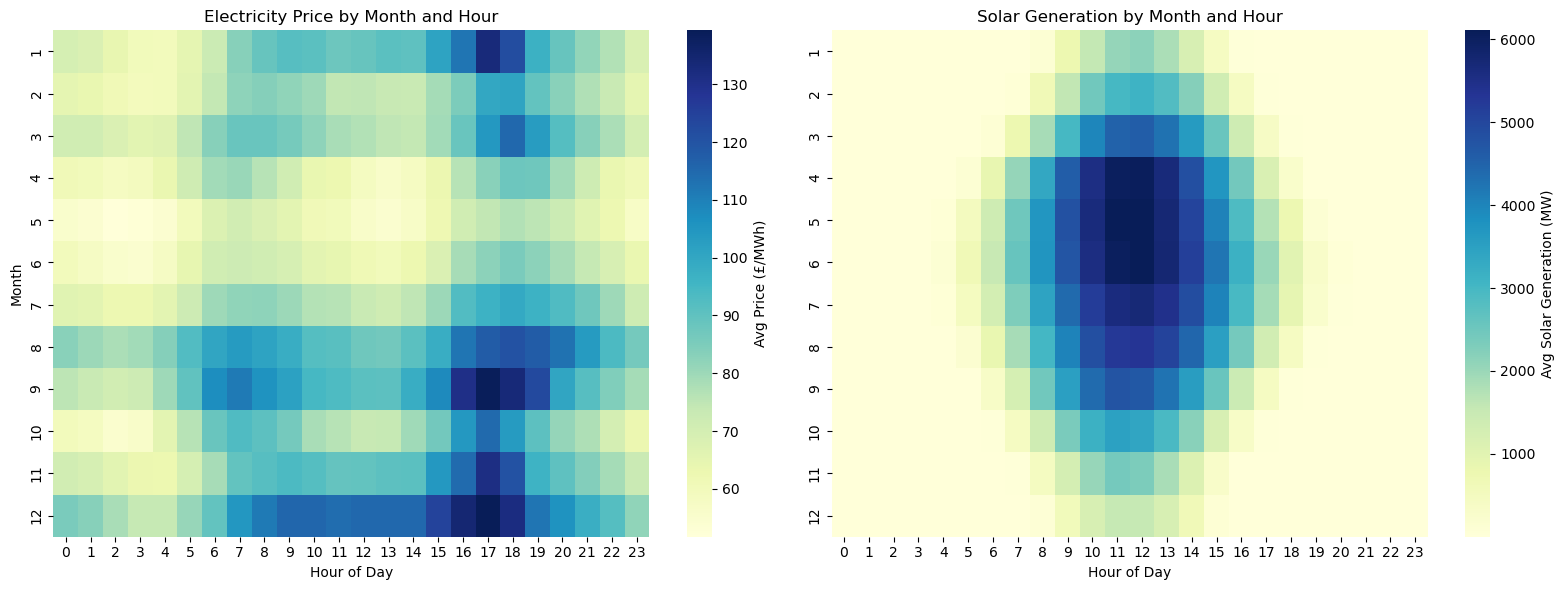

In [319]:
# Extract hour and month
merged_df['hour'] = merged_df['StartTime'].dt.hour
merged_df['month'] = merged_df['StartTime'].dt.month

# Create pivot tables
price_pivot = merged_df.groupby(['month', 'hour'])['Price'].mean().unstack()
solar_pivot = merged_df.groupby(['month', 'hour'])['Solar'].mean().unstack()

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Shared color map
shared_cmap = 'YlGnBu'

# Heatmap for electricity price
sns.heatmap(price_pivot, ax=axes[0], cmap=shared_cmap, cbar_kws={"label": "Avg Price (£/MWh)"})
axes[0].set_title('Electricity Price by Month and Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Month')

# Heatmap for solar generation using same colormap
sns.heatmap(solar_pivot, ax=axes[1], cmap=shared_cmap, cbar_kws={"label": "Avg Solar Generation (MW)"})
axes[1].set_title('Solar Generation by Month and Hour')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

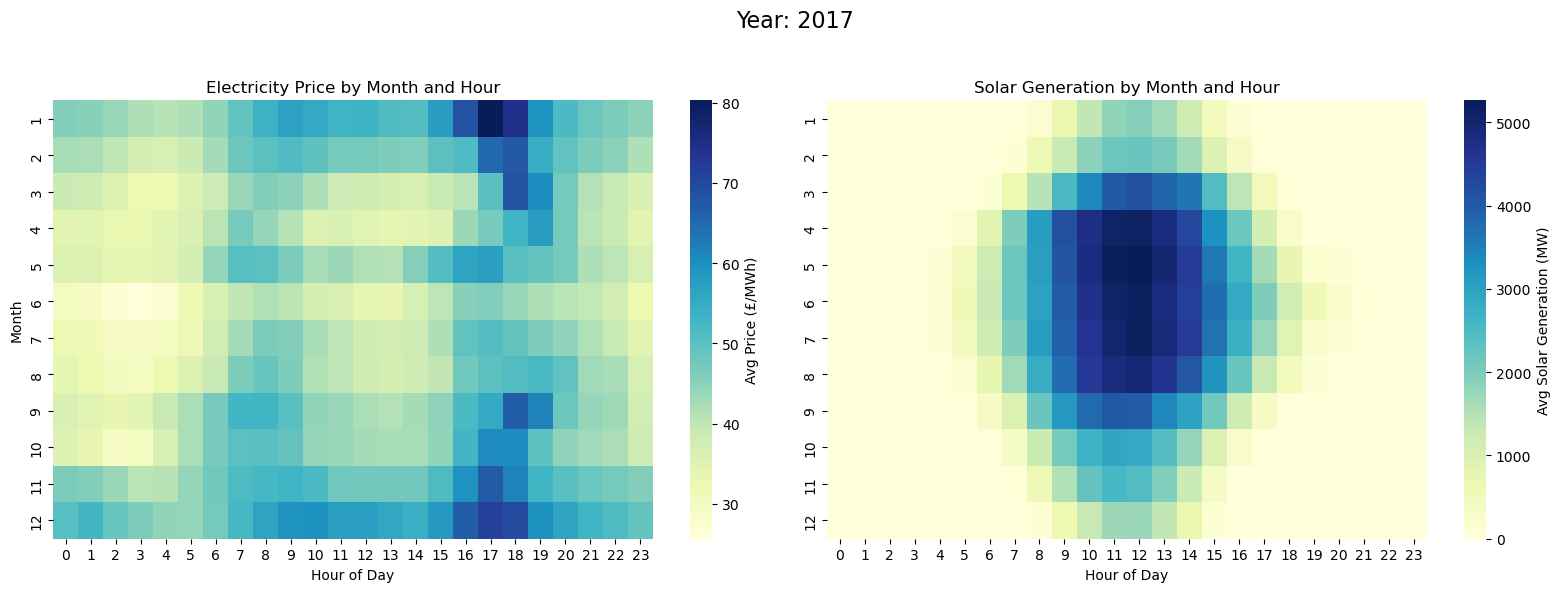

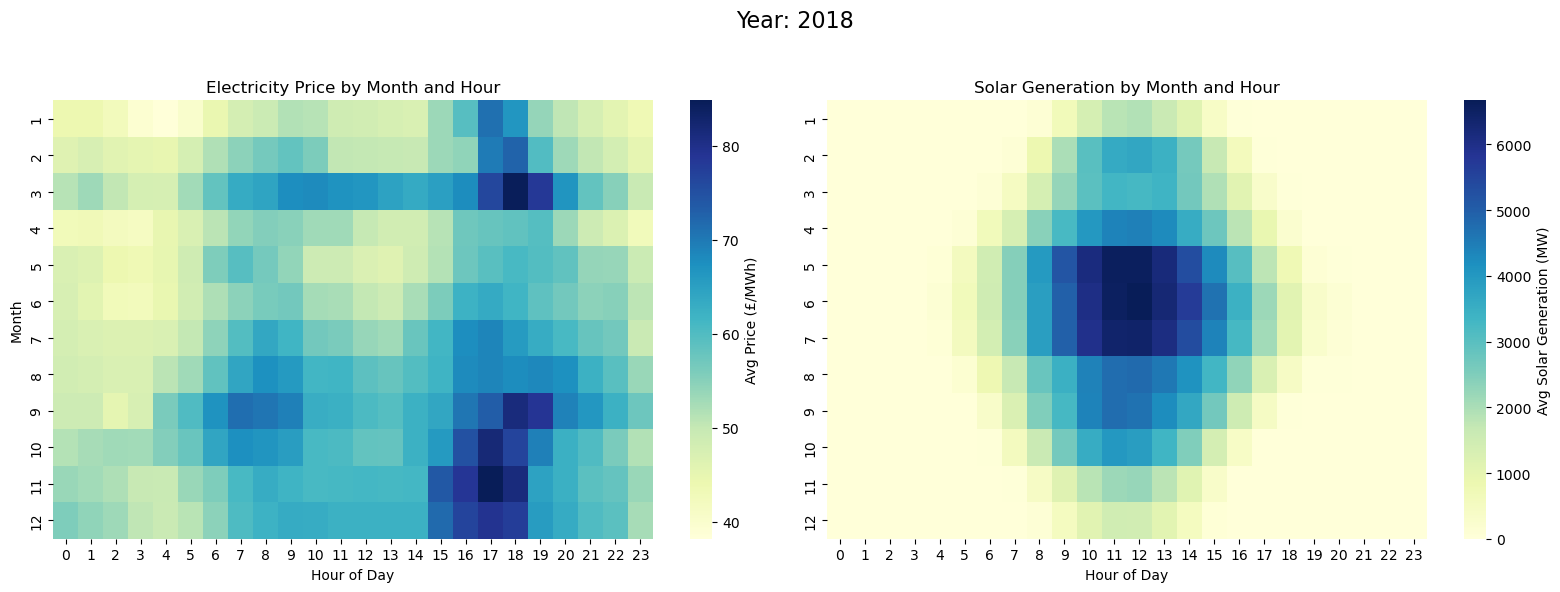

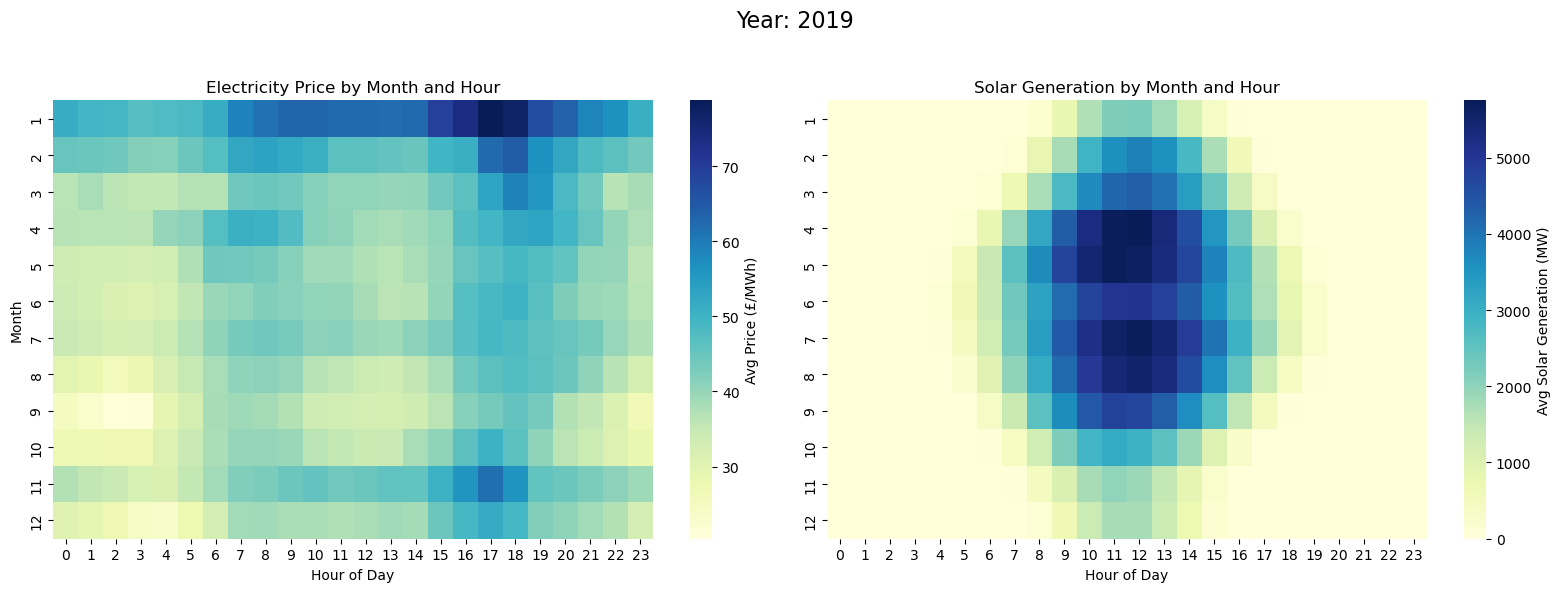

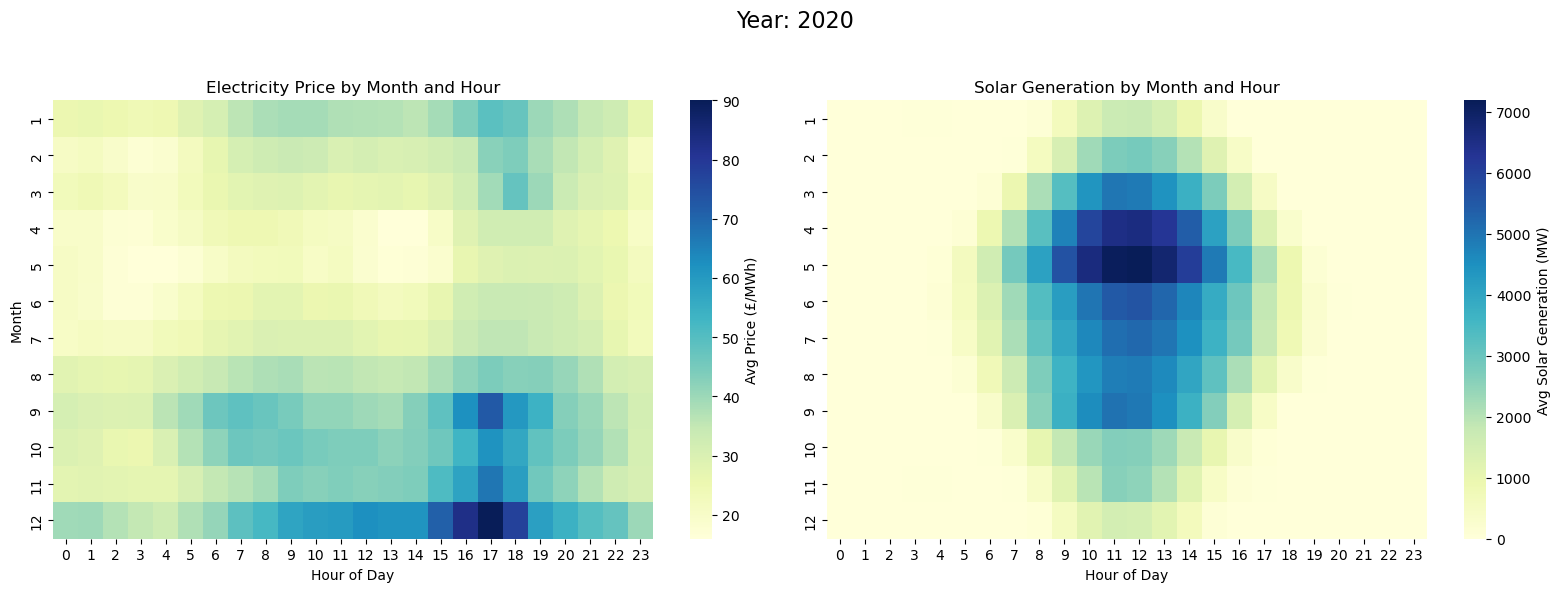

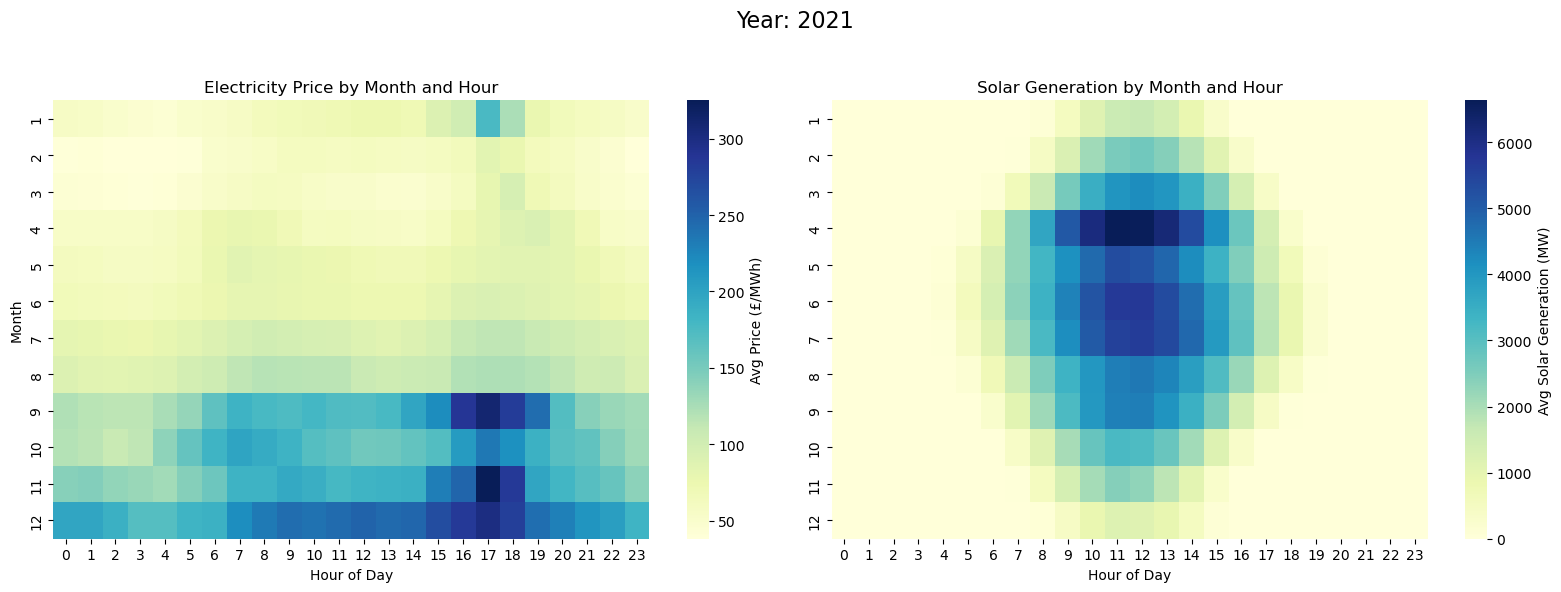

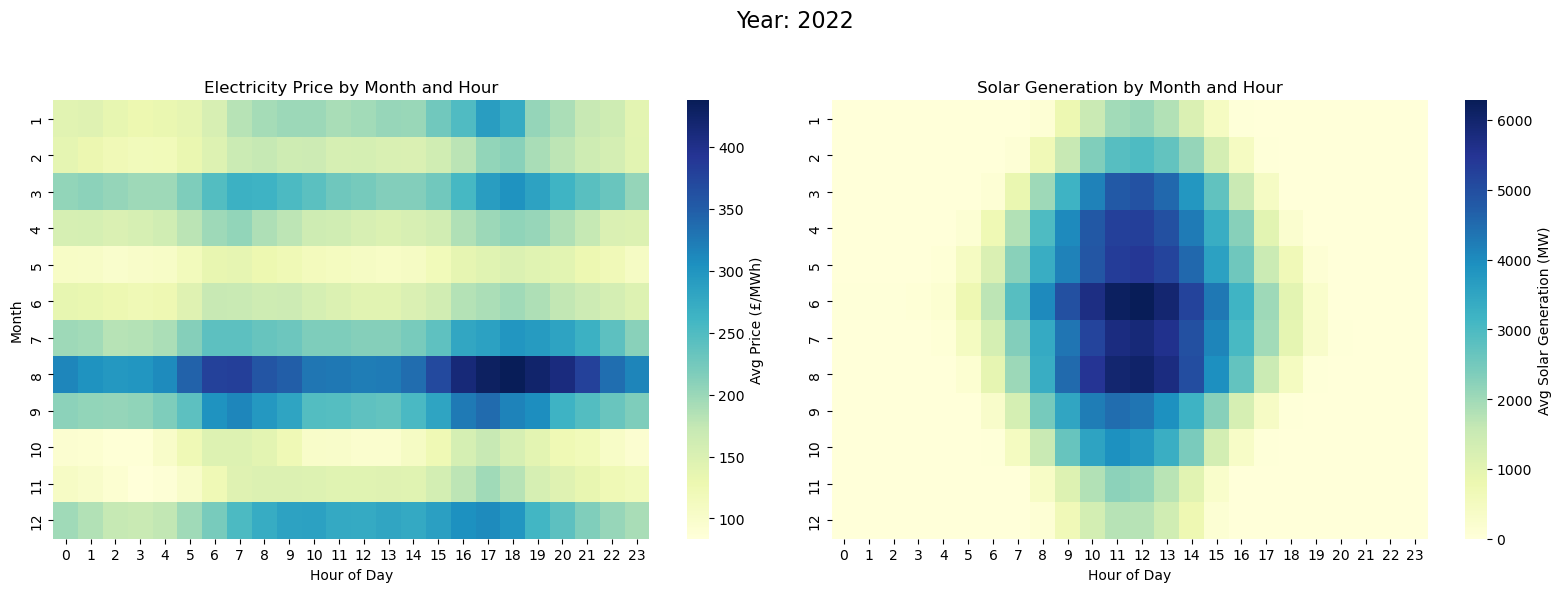

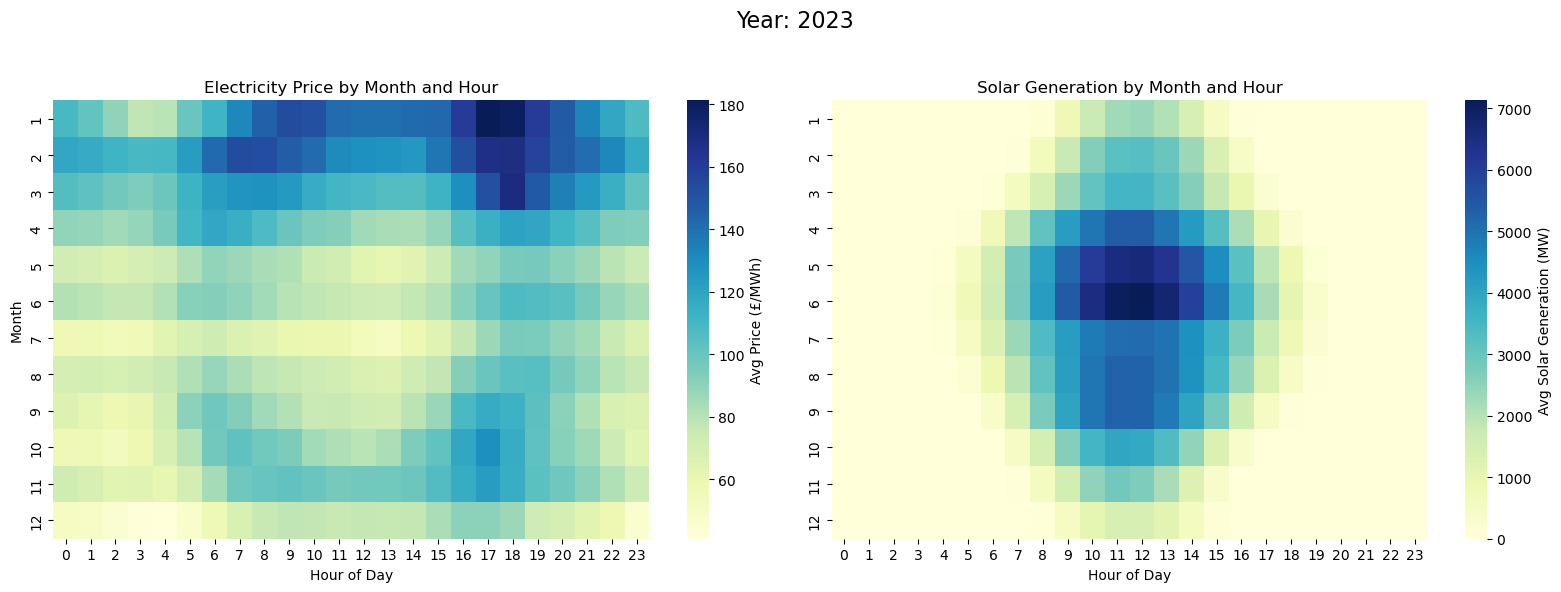

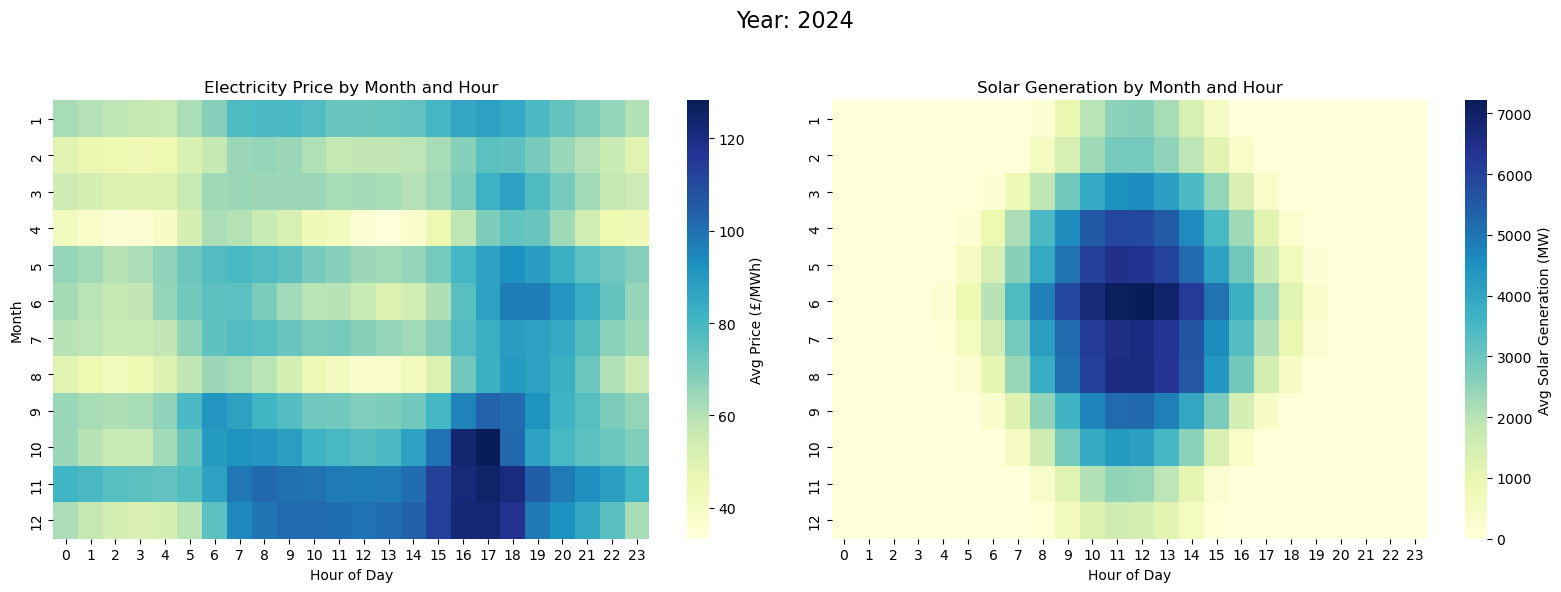

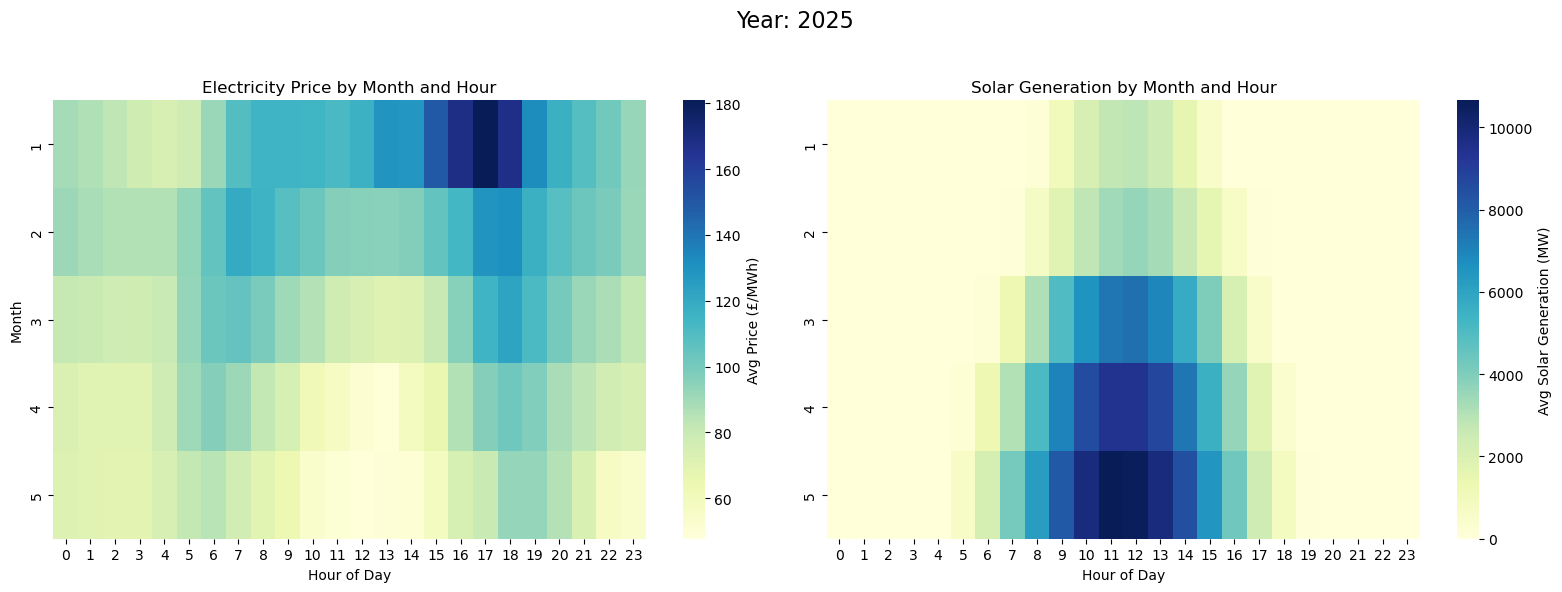

In [320]:
# Extract time components
merged_df['hour'] = merged_df['StartTime'].dt.hour
merged_df['month'] = merged_df['StartTime'].dt.month
merged_df['year'] = merged_df['StartTime'].dt.year

# List of available years
years = sorted(merged_df['year'].unique())

# Shared colormap
shared_cmap = 'YlGnBu'

# Loop through years
for year in years:
    df_year = merged_df[merged_df['year'] == year]

    # Create pivot tables
    price_pivot = df_year.groupby(['month', 'hour'])['Price'].mean().unstack()
    solar_pivot = df_year.groupby(['month', 'hour'])['Solar'].mean().unstack()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Year: {year}', fontsize=16)

    # Price heatmap
    sns.heatmap(price_pivot, ax=axes[0], cmap=shared_cmap, cbar_kws={"label": "Avg Price (£/MWh)"})
    axes[0].set_title('Electricity Price by Month and Hour')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Month')

    # Solar heatmap
    sns.heatmap(solar_pivot, ax=axes[1], cmap=shared_cmap, cbar_kws={"label": "Avg Solar Generation (MW)"})
    axes[1].set_title('Solar Generation by Month and Hour')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## 5.2 Model fit & Instrument validity

In [322]:
merged_df["Wind"] = merged_df["Wind Onshore"] + merged_df["Wind Offshore"]

# 1. First-stage: Instrument Solar using solar radiation
first_stage = sm.OLS(merged_df["Solar"], sm.add_constant(merged_df["solar_radiation_W_m2"])).fit()

# 2. Get residuals from the first stage (the unexplained part)
merged_df["Solar_hat"] = first_stage.fittedvalues
merged_df["Solar_resid"] = merged_df["Solar"] - merged_df["Solar_hat"]

# 3. Second-stage: Regress Price on Solar and the residuals
# This tests whether the residuals still explain Price ⇒ if so, endogeneity exists
wu_test_model = sm.OLS.from_formula(
    'Price ~ 1 + Wind + Volume + C(hour) + Solar + Solar_resid',
    data=merged_df
).fit()

# 4. Check if Solar_resid is significant
print(wu_test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     183.2
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        18:15:05   Log-Likelihood:            -4.1465e+05
No. Observations:               73080   AIC:                         8.294e+05
Df Residuals:                   73052   BIC:                         8.296e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.6665      1.342     49.676

In [323]:
merged_df["Wind"] = merged_df["Wind Onshore"] + merged_df["Wind Offshore"]

# First-stage regression
first_stage = sm.OLS(merged_df["Solar"], sm.add_constant(merged_df["solar_radiation_W_m2"])).fit()
merged_df["Solar_hat"] = first_stage.fittedvalues
merged_df["Solar_resid"] = merged_df["Solar"] - merged_df["Solar_hat"]

# Second-stage regression including residual to test endogeneity
wu_test_model = sm.OLS.from_formula(
    'Price ~ 1 + Wind + Volume + C(hour) + Solar + Solar_resid',
    data=merged_df
).fit()

print(wu_test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     183.2
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        18:15:06   Log-Likelihood:            -4.1465e+05
No. Observations:               73080   AIC:                         8.294e+05
Df Residuals:                   73052   BIC:                         8.296e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.6665      1.342     49.676

In [324]:
# First-stage regression with controls
first_stage = ols('Solar ~ solar_radiation_W_m2 + Wind + Volume + C(hour) + C(month)', data=merged_df).fit()

print(first_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                  Solar   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 1.281e+04
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        18:15:07   Log-Likelihood:            -5.8638e+05
No. Observations:               73080   AIC:                         1.173e+06
Df Residuals:                   73042   BIC:                         1.173e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -99.1406 

## 5.3 2SLS

In [326]:
# IV regression
formula_2sls = 'Price ~ 1 + Wind + Volume + C(hour) + [Solar ~ solar_radiation_W_m2]'
iv_model = IV2SLS.from_formula(formula_2sls, data=merged_df).fit(cov_type='robust')

print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  Price   R-squared:                      0.0618
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0615
No. Observations:               73080   F-statistic:                    4508.6
Date:                Mon, Jun 23 2025   P-value (F-stat)                0.0000
Time:                        18:15:08   Distribution:                 chi2(26)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         65.911     2.9766     22.143     0.0000      60.077      71.745
Wind             -0.0017     0.0007    -

## 5.4 Robustness check

In [328]:
# Define seasons based on months
# Winter: December (12), January (1), February (2)
# Summer: June (6), July (7), August (8)
merged_df['season'] = merged_df['month'].map(lambda m: 'winter' if m in [12, 1, 2] else ('summer' if m in [6, 7, 8] else 'other'))

# Filter datasets
winter_df = merged_df[merged_df['season'] == 'winter'].copy()
summer_df = merged_df[merged_df['season'] == 'summer'].copy()

# 2SLS formula
formula = 'Price ~ 1 + Wind + Volume + C(hour) + [Solar ~ solar_radiation_W_m2]'

# Fit model for Winter
iv_winter = IV2SLS.from_formula(formula, data=winter_df).fit(cov_type='robust')

# Fit model for Summer
iv_summer = IV2SLS.from_formula(formula, data=summer_df).fit(cov_type='robust')

# Print results
print("==== Winter Season Results ====")
print(iv_winter.summary)
print("\n==== Summer Season Results ====")
print(iv_summer.summary)

==== Winter Season Results ====
                          IV-2SLS Estimation Summary                          
Dep. Variable:                  Price   R-squared:                      0.1152
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1140
No. Observations:               18744   F-statistic:                    2025.8
Date:                Mon, Jun 23 2025   P-value (F-stat)                0.0000
Time:                        18:15:08   Distribution:                 chi2(26)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         81.944     2.2465     36.477     0.0000      77.541      86.347
Wind    